# Project 3 - Classify your own data

For this project we're going to explore some of the new topics since the last project including Decision Trees and Un-supervised learning. The final part of the project will ask you to perform your own data science project to classify a new dataset.



## Submission Details

**Project is due June 14th at 11:59 am (Wednesday Afternoon). To submit the project, please save the notebook
as a pdf file and submit the assignment via Gradescope. In addition, make sure that
all figures are legible and suﬀiciently large. For best pdf results, we recommend downloading [Latex](https://www.latex-project.org/) and print the notebook using Latex.**

## Loading Essentials and Helper Functions 

In [3]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib
import os
import time
#Sklearn classes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix,silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs

from matplotlib import pyplot
import itertools

%matplotlib inline

#Sets random seed
import random 
random.seed(42) 

In [4]:
#Helper functions
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.YlOrBr)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=0)
    plt.yticks(np.arange(num_classes), classes)
    plt.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.gca().xaxis.set_label_position('top')
    plt.tight_layout()
    plt.show()
    
def heatmap(data, row_labels, col_labels, figsize = (20,12), cmap = "YlGn",
            cbar_kw={}, cbarlabel="", valfmt="{x:.2f}",
            textcolors=("black", "white"), threshold=None):
    """
    Create a heatmap from a numpy array and two lists of labels. 
    
    Taken from matplotlib example.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cmap
        A string that specifies the colormap to use. Look at matplotlib docs for information.
        Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
    """

    plt.figure(figsize = figsize)
    ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data,cmap=cmap)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    
    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)


def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def draw_contour(x,y,clf, class_labels = ["Negative", "Positive"]):
    """
    Draws a contour line for the predictor
    
    Assumption that x has only two features. This functions only plots the first two columns of x.
    
    """
    
    X0, X1 = x[:, 0], x[:, 1]
    xx0, xx1 = make_meshgrid(X0,X1)
    
    plt.figure(figsize = (10,6))
    plot_contours(clf, xx0, xx1, cmap="PiYG", alpha=0.8)
    scatter=plt.scatter(X0, X1, c=y, cmap="PiYG", s=30, edgecolors="k")
    plt.legend(handles=scatter.legend_elements()[0], labels=class_labels)

    plt.xlim(xx0.min(), xx0.max())
    plt.ylim(xx1.min(), xx1.max())
    


# Example Project using new techniques 

Since project 2, we have learned about a few new models for supervised learning(Decision Trees and Neural Networks) and un-supervised learning (Clustering and PCA). In this example portion, we will go over how to implement these techniques using the Sci-kit learn library.

## Load and Process Example Project Data


For our example dataset, we will use the [Breast Cancer Wisconsin Dataset](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) to determine whether a mass found in a body is benign or malignant. Since this dataset was used as an example in project 2, you should be fairly familiar with it.

Feature Information:

Column 1: ID number

Column 2: Diagnosis (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus:

    1. radius (mean of distances from center to points on the perimeter)
    2. texture (standard deviation of gray-scale values)
    3. perimeter
    4. area
    5. smoothness (local variation in radius lengths)
    6. compactness (perimeter^2 / area - 1.0)
    7. concavity (severity of concave portions of the contour)
    8. concave points (number of concave portions of the contour)
    9. symmetry
    10. fractal dimension ("coastline approximation" - 1)

Due to the statistical nature of the test, we are not able to get exact measurements of the previous values. Instead, the dataset contains the mean and standard error of the real-valued features. 

Columns 3-12 present the mean of the measured values

Columns 13-22 present the standard error of the measured values

In [5]:
#Preprocess Data

#Load Data
data = pd.read_csv('datasets/breast_cancer_data.csv')

#Drop id column
data = data.drop(["id"],axis= 1)

#Transform target feature into numerical
le = LabelEncoder() 
data['diagnosis'] = le.fit_transform(data['diagnosis'])

#Split target and data
y = data["diagnosis"]
x = data.drop(["diagnosis"],axis = 1)

#Train test split
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.2, stratify= y, random_state=0)

#Standardize data
#Since all features are real-valued, we only have one pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

#Transform raw data 
train = pipeline.fit_transform(train_raw)
test = pipeline.transform(test_raw) #Note that there is no fit calls

#Names of Features after Pipeline
feature_names = list(pipeline.get_feature_names_out(list(x.columns)))

In [6]:
target.value_counts()

0    285
1    170
Name: diagnosis, dtype: int64

In [7]:
#Baseline accuracy of using the majority class 
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print("Baseline Accuraccy of using Majority Class: ", np.max(ct)/np.sum(ct))

Counts of each class in target_test: 
0    72
1    42
Name: diagnosis, dtype: int64
Baseline Accuraccy of using Majority Class:  0.631578947368421


## Supervised Learning: Decision Tree


### Classification with Decision Tree

In [8]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)

Accuracy:    0.894737
Confusion Matrix: 
 [[63  9]
 [ 3 39]]


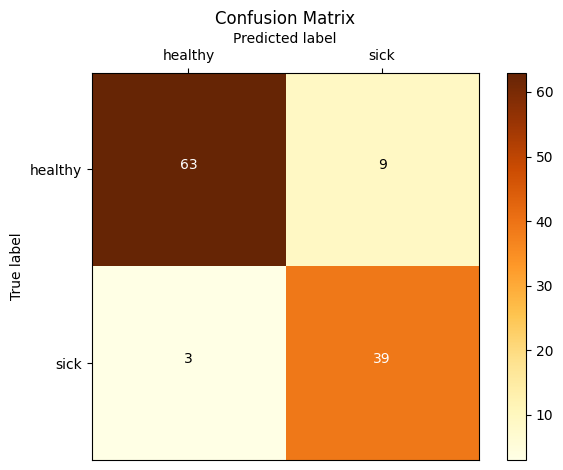

In [9]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

###  Parameters for Decision Tree Classifier

In Sci-kit Learn, the following are just some of the parameters we can pass into the Decision Tree Classifier:

- criterion: {‘gini’, ‘entropy’, ‘log_loss’} default="gini"
    - The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain 
- splitter: {“best”, “random”}, default=”best”
    - The strategy used to choose the split at each node. “best” aims to find the best feature split amongst all features. "random" only looks for the best split amongst a random subset of features.
- max_depth: int, default = 2 {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
    - The maximum depth of the tree.
- min_samples_split: int or float, default=2
    - The minimum number of samples required to split an internal node. If int, then consider min_samples_split as the minimum number. If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

### Visualizing Decision Trees

Scikit-learn allows us to visualize the decision tree to see what features it choose to split and what the result is. Note that if the condition in the node is true, you traverse the left edge of the node. Otherwise, you traverse the right edge.

[Text(0.5, 0.8333333333333334, 'concave points_mean <= 0.011\ngini = 0.468\nsamples = 100.0%\nvalue = [0.626, 0.374]'),
 Text(0.25, 0.5, 'area_mean <= 0.124\ngini = 0.101\nsamples = 61.5%\nvalue = [0.946, 0.054]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'concavity_mean <= 0.001\ngini = 0.202\nsamples = 38.5%\nvalue = [0.114, 0.886]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

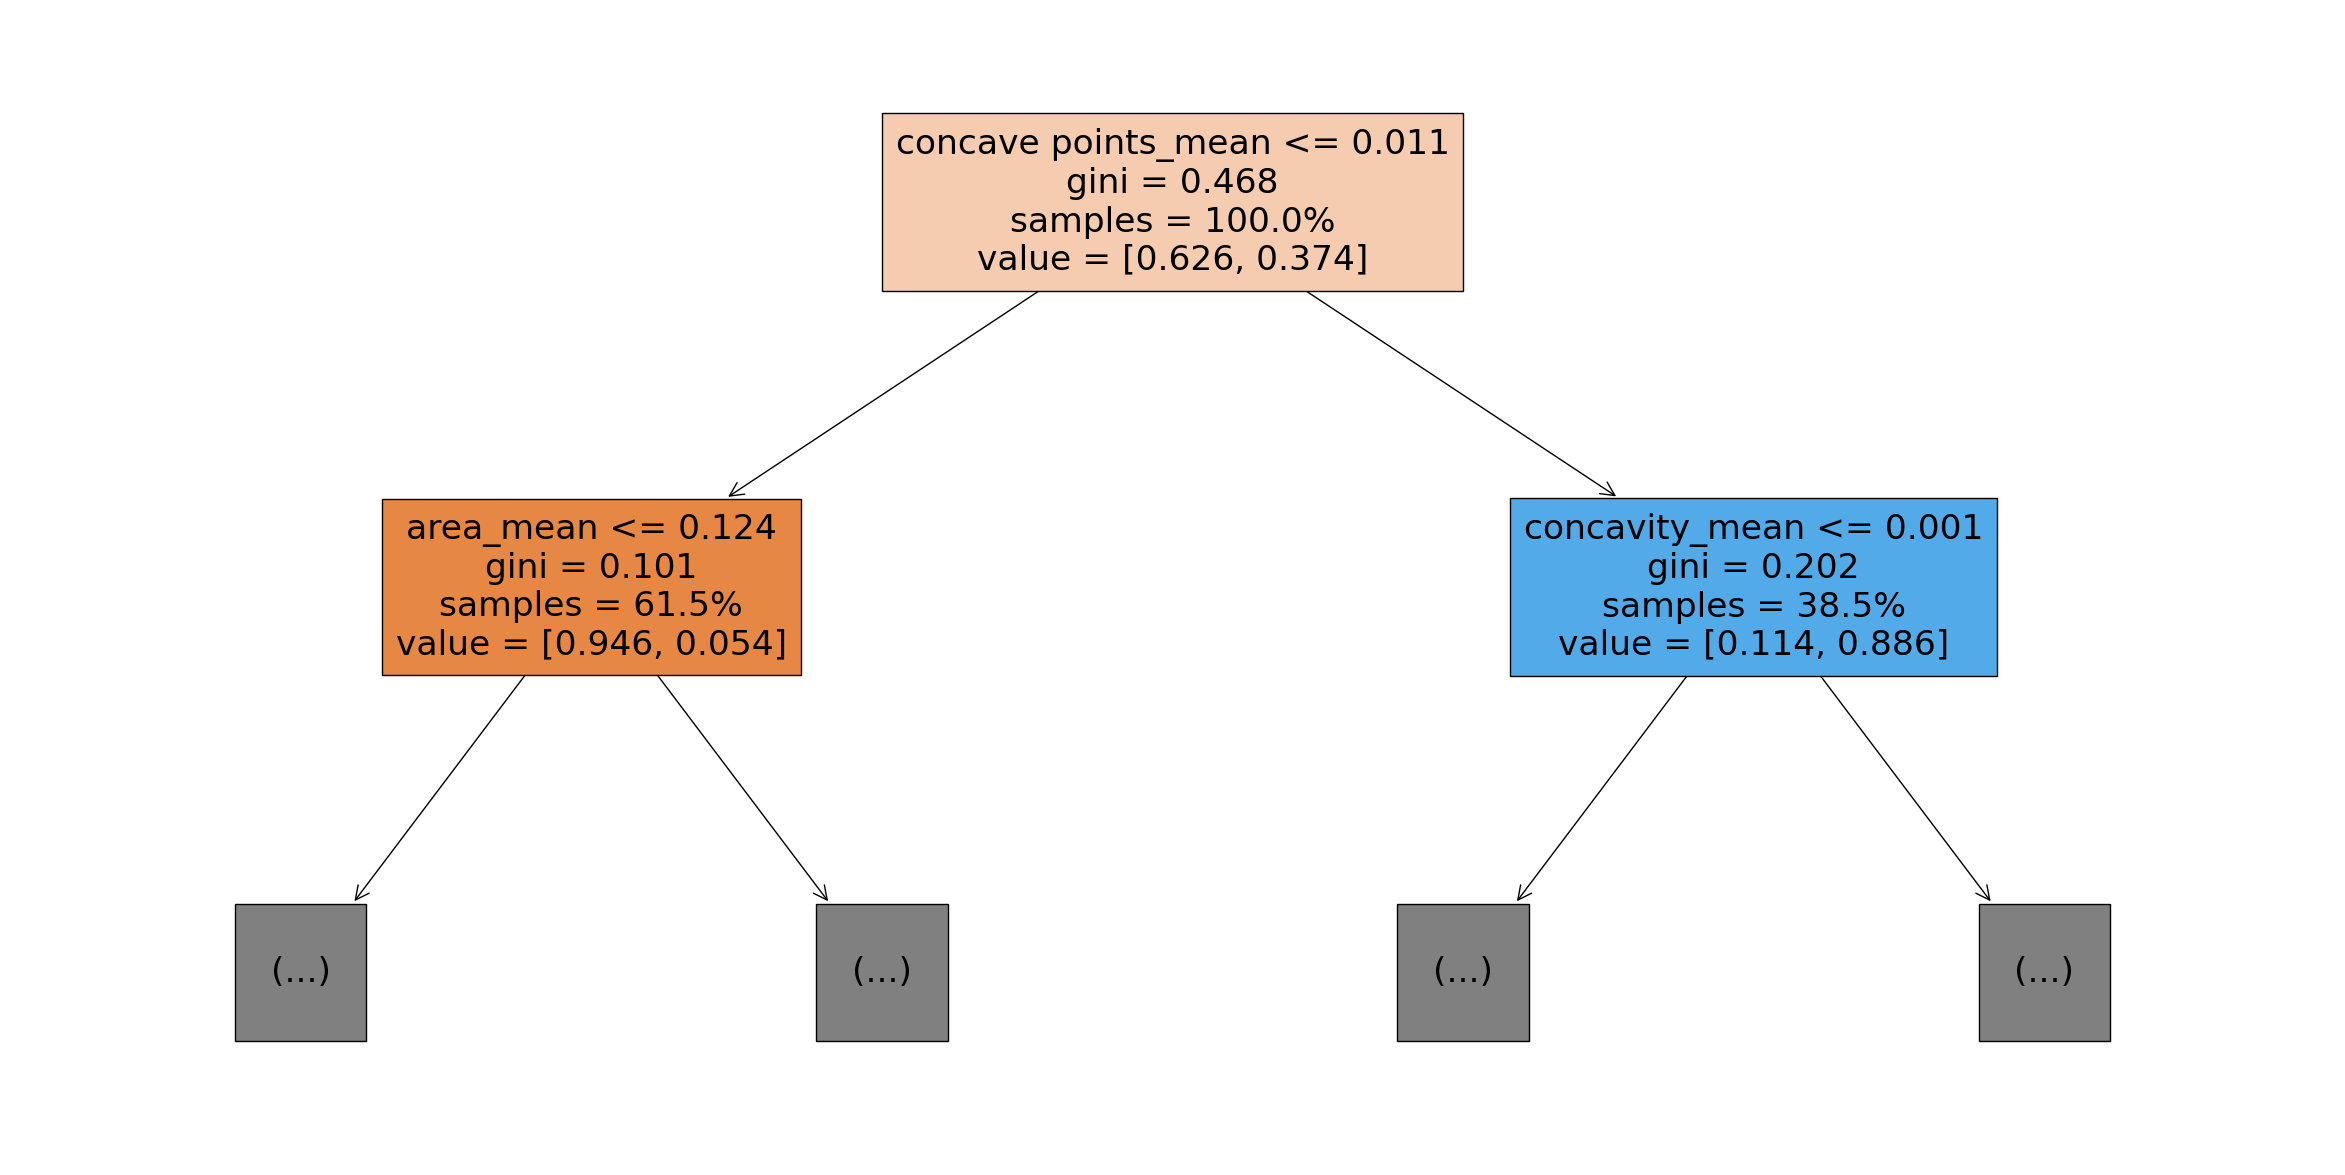

In [10]:
plt.figure(figsize = (30,15)) 
#Note that we have to pass the feature names into the plotting function to get the actual names
#We pass the column names through the pipeline in case any feature augmentation was made
#For example, a categorical feature will be split into multiple features with one hot encoding
#and this way assigns a name to each column based on the feature value and the original feature name
tree.plot_tree(clf,max_depth=1, proportion=True,feature_names=feature_names, filled=True)

We can even look at the tree in a textual format.

In [11]:
from sklearn.tree import export_text
r = export_text(clf, feature_names=feature_names)
print(r)

|--- concave points_mean <= 0.01
|   |--- area_mean <= 0.12
|   |   |--- area_se <= 0.04
|   |   |   |--- compactness_mean <= 0.59
|   |   |   |   |--- fractal_dimension_se <= -0.83
|   |   |   |   |   |--- fractal_dimension_se <= -0.84
|   |   |   |   |   |   |--- smoothness_se <= -1.22
|   |   |   |   |   |   |   |--- compactness_se <= -0.98
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- compactness_se >  -0.98
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- smoothness_se >  -1.22
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- fractal_dimension_se >  -0.84
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- fractal_dimension_se >  -0.83
|   |   |   |   |   |--- class: 0
|   |   |   |--- compactness_mean >  0.59
|   |   |   |   |--- symmetry_se <= 0.20
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- symmetry_se >  0.20
|   |   |   |   |   |--- class: 0
|   |   |--- area_se >  0.04
|   |   |   

### Feature Importance in Decision Trees

Decision Trees can also assign importance to features by measuring the average decrease in impurity (i.e. information gain) for each feature. The features with higher decreases are treated as more important. 

<Axes: >

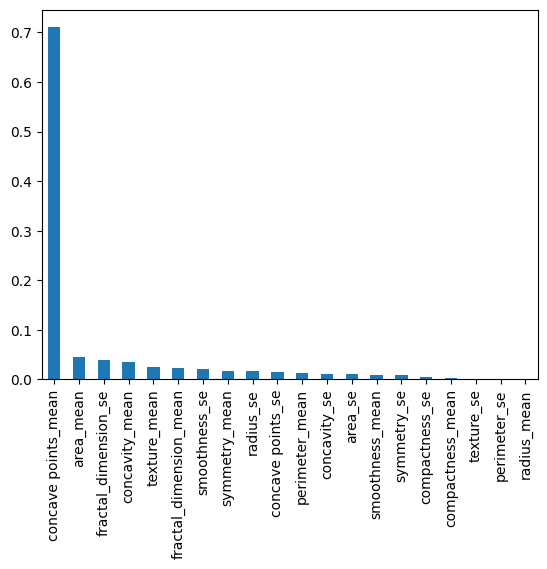

In [12]:
imp_pd = pd.Series(data = clf.feature_importances_ ,index = feature_names)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

We can clearly see that "concave points_mean" has the largest importance due to it providing the most reduction in the impurity.

### Visualizing decision boundaries for Decision Trees

Similar to project 2, lets see what decision boundaries that a Decision Tree creates. We use the two most correlated features to the target labels: concave_points_mean and perimeter_mean. 

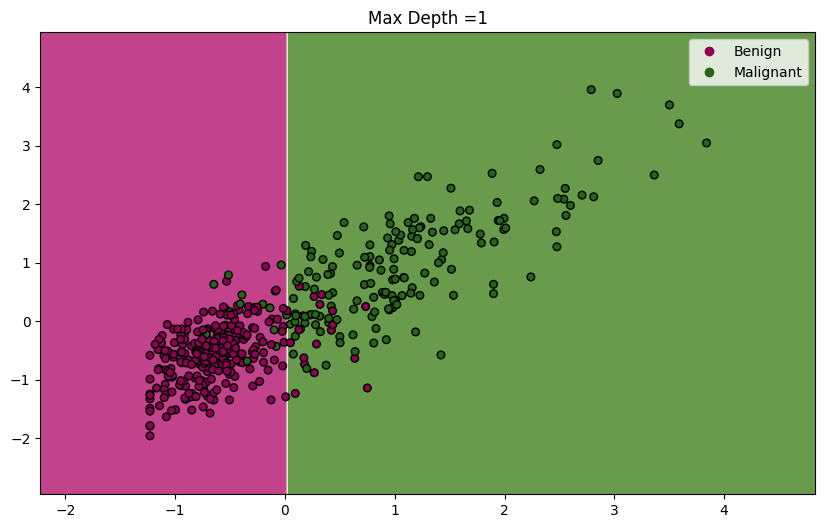

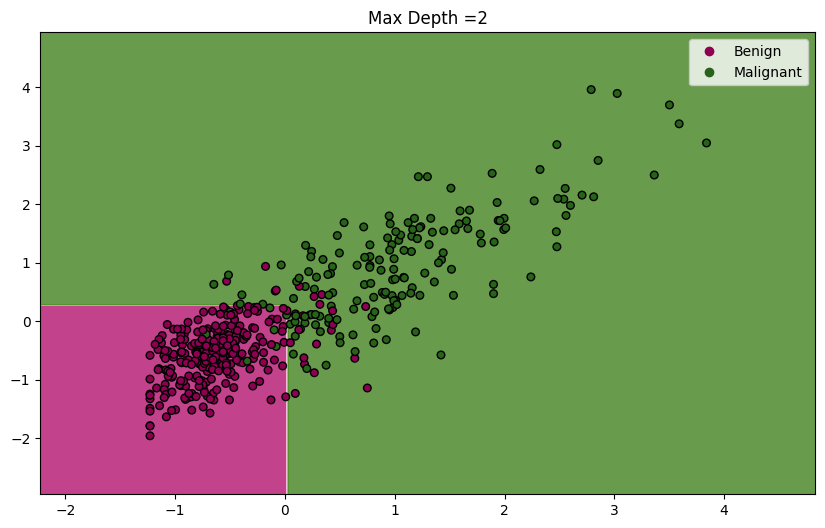

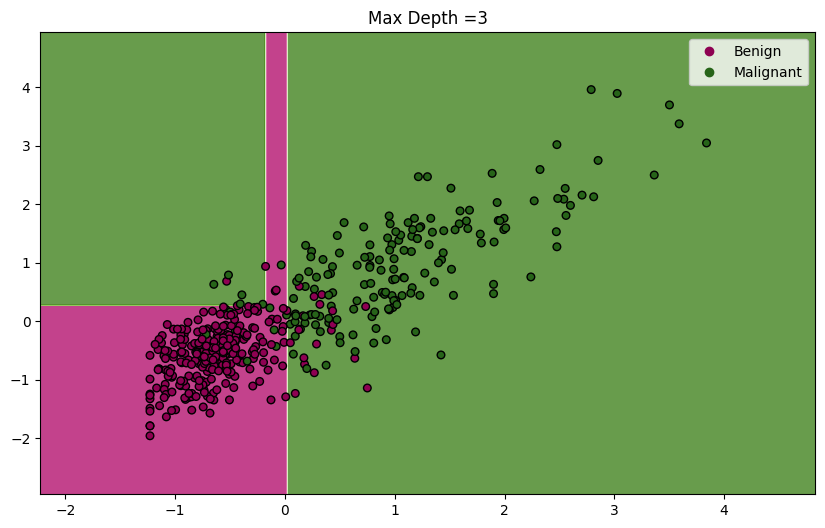

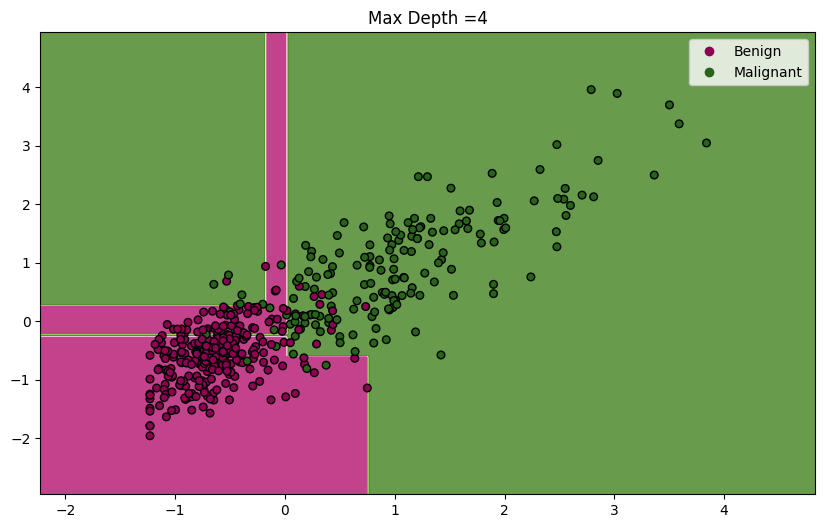

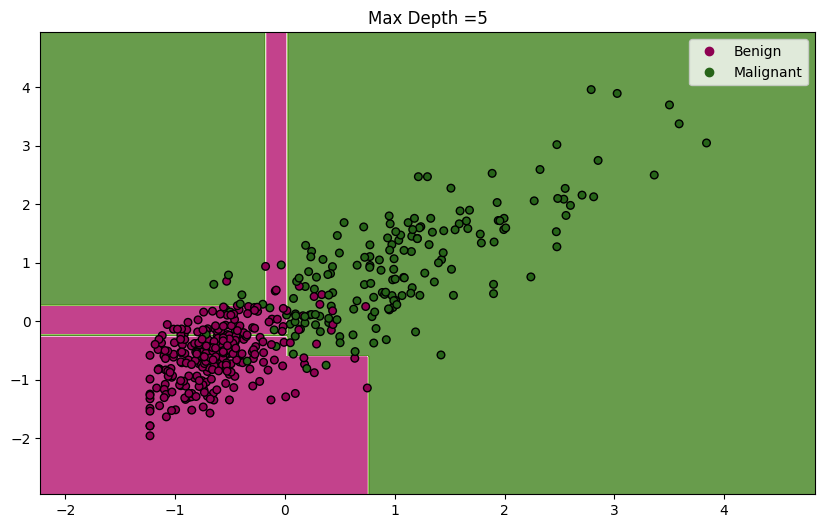

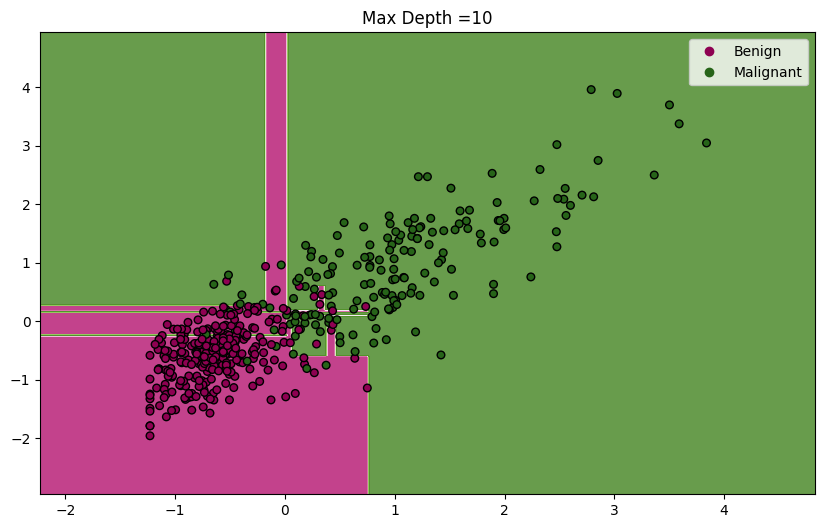

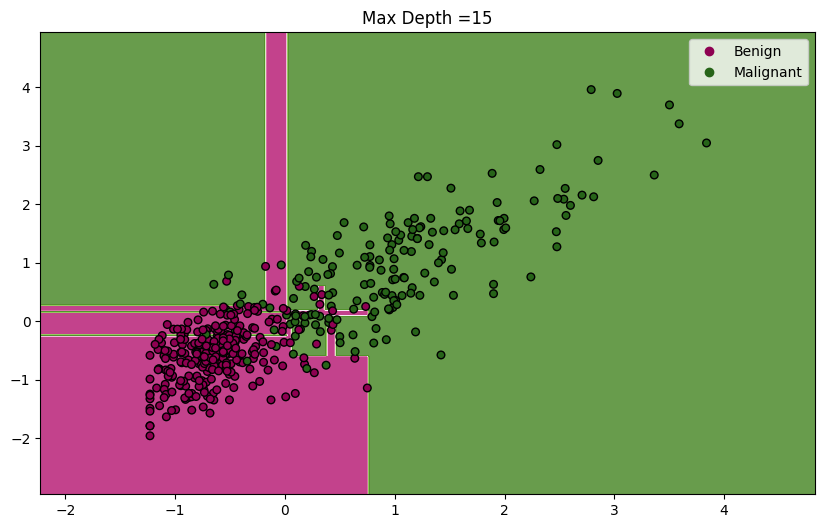

In [13]:
#Extract first two feature and use the standardscaler 
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

depth  = [1,2,3,4,5,10,15]
for d in depth:
    dt = DecisionTreeClassifier(max_depth = d, min_samples_split=7) 
    dt.fit(train_2, target)
    draw_contour(train_2,target,dt,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Max Depth ={d}")

We can see that the model gets more and more complex with increasing depth until it converges somewhere in between depth 10 and 15. 

## Supervised Learning: Multi-Layer Perceptron (MLP)

A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. Neural networks are very powerful tools that are used a in a variety of applications including image and speech processing. In class, we have discussed one of the earliest types of neural networks known as a Multi-Layer Perceptron. 

![steps](jupyter_images/mlp_example.png)

### Using MLP for classification

In [14]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter = 400)
clf.fit(train, target)
predicted = clf.predict(test)

Accuracy:    0.947368
Confusion Matrix: 
 [[67  5]
 [ 1 41]]


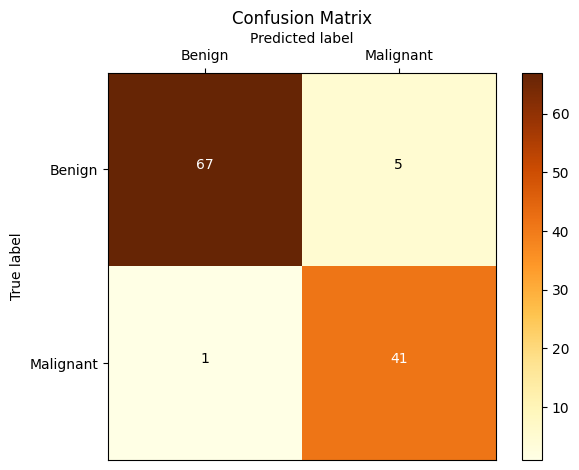

In [15]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

###  Parameters for MLP Classifier

In Sci-kit Learn, the following are just some of the parameters we can pass into MLP Classifier:

- hidden_layer_sizes: tuple, length = n_layers - 2, default=(100,)
    - The ith element represents the number of neurons in the ith hidden layer. 
- activation: {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
    - Activation function for the hidden layer.
- alpha: float, default = 0.0001
    - Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
- max_iter: int, default=200
    - Maximum number of iterations taken for the solvers to converge.

### Visualizing decision boundaries for MLP

Now, lets see how the decision boundaries change as a function of both the activation function and the number of hidden layers.

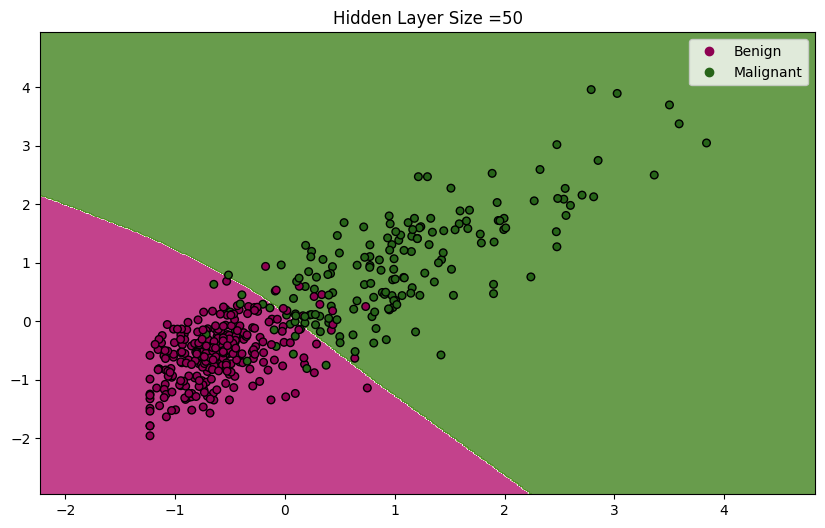

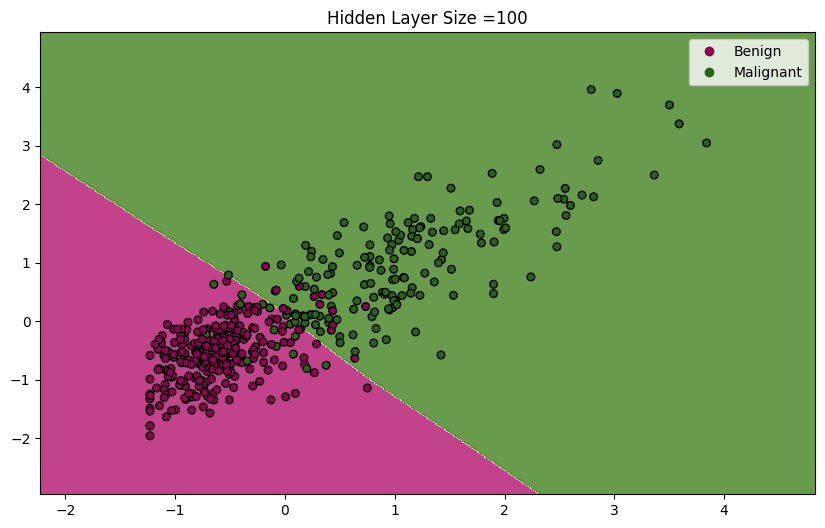

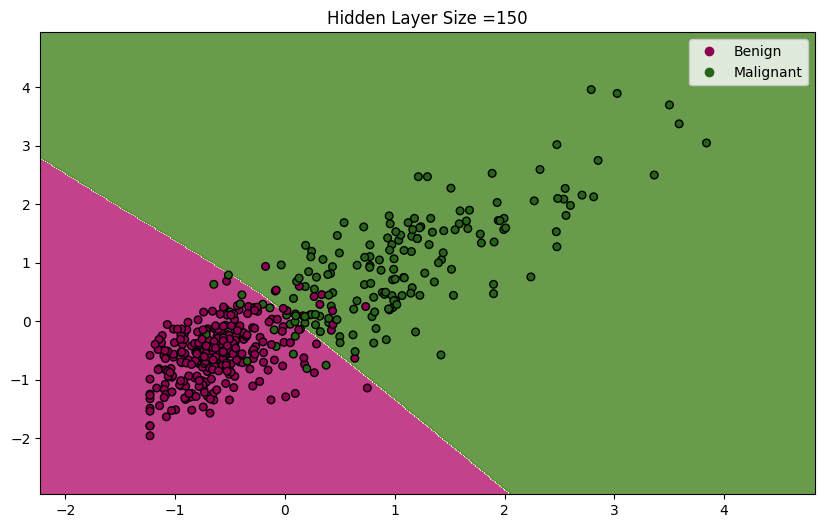

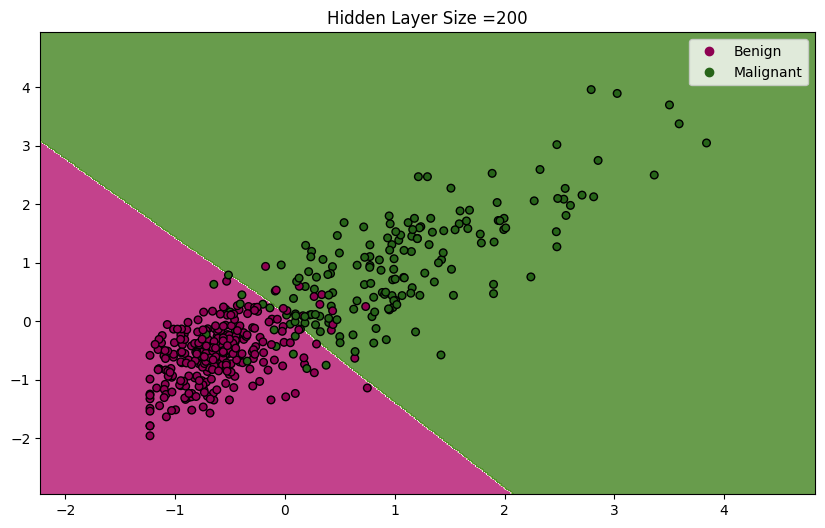

In [16]:
#Example of using the default Relu activation while altering the number of hidden layers
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

layers  = [50,100,150,200]
for l in layers:
    mlp = MLPClassifier(hidden_layer_sizes=(l,), max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Hidden Layer Size ={l}")

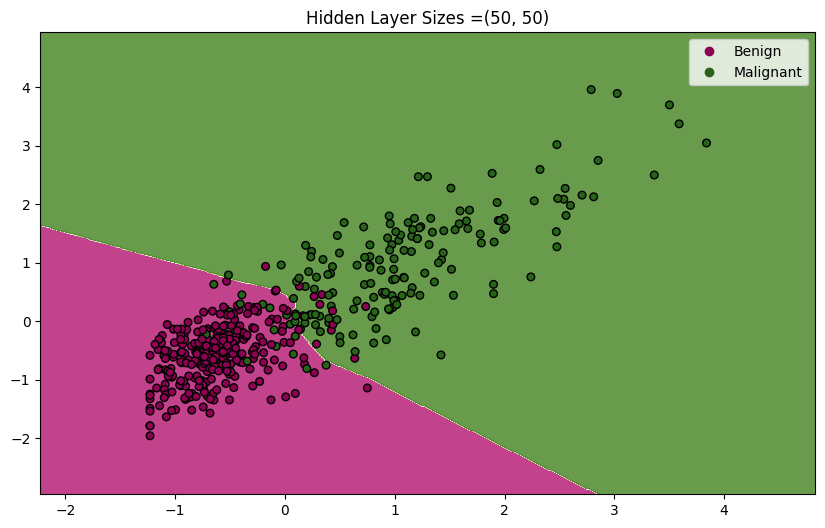

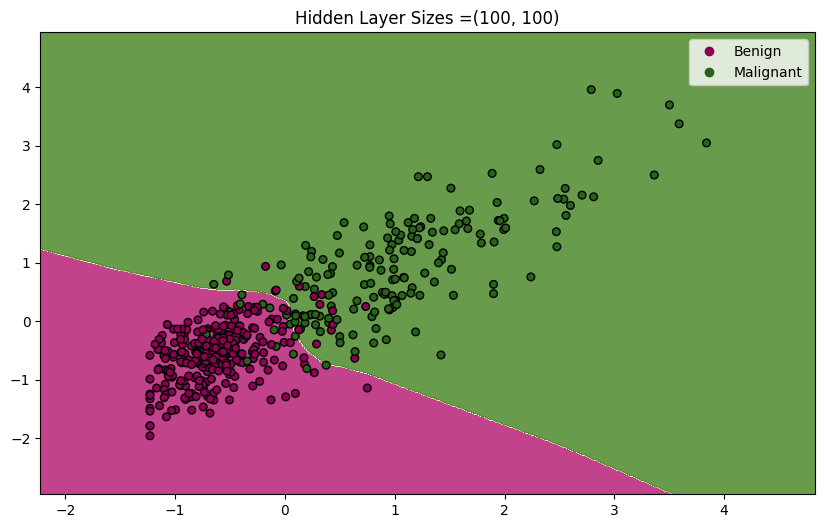

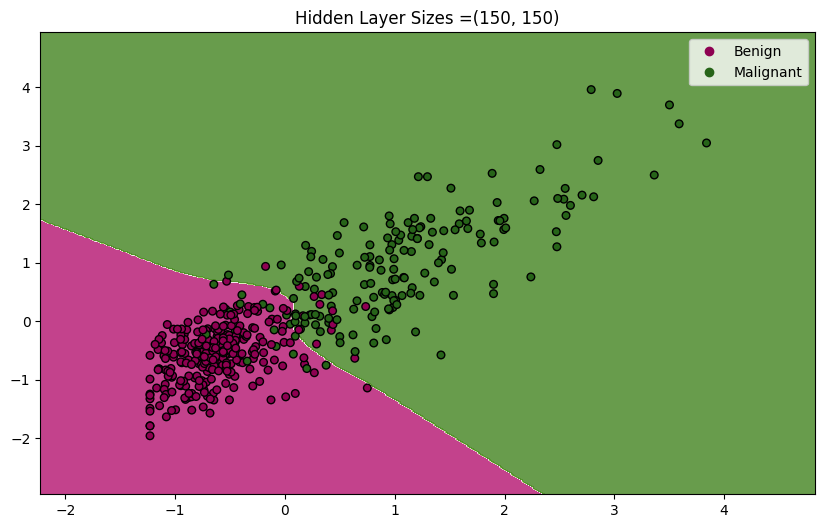

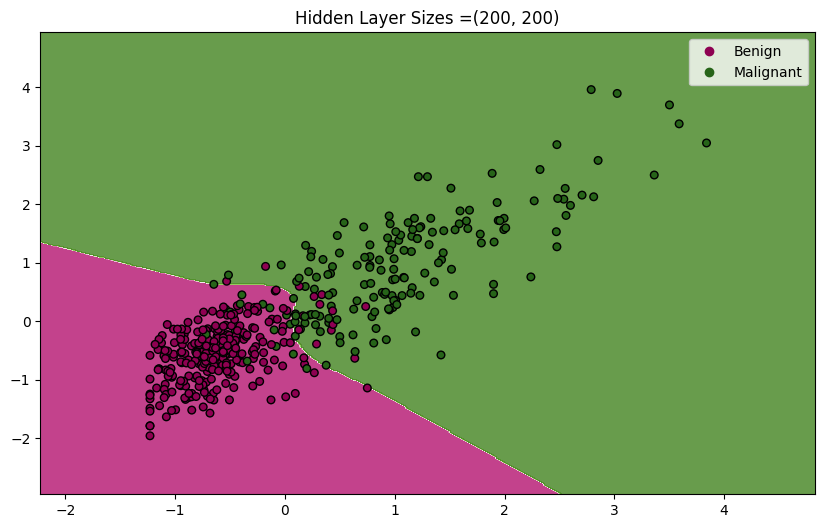

In [17]:
#Example of using the default Relu activation 
#while altering the number of hidden layers with 2 groups of hidden layers
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

layers  = [50,100,150,200]
for l in layers:
    mlp = MLPClassifier(hidden_layer_sizes=(l,l), max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Hidden Layer Sizes ={(l,l)}")

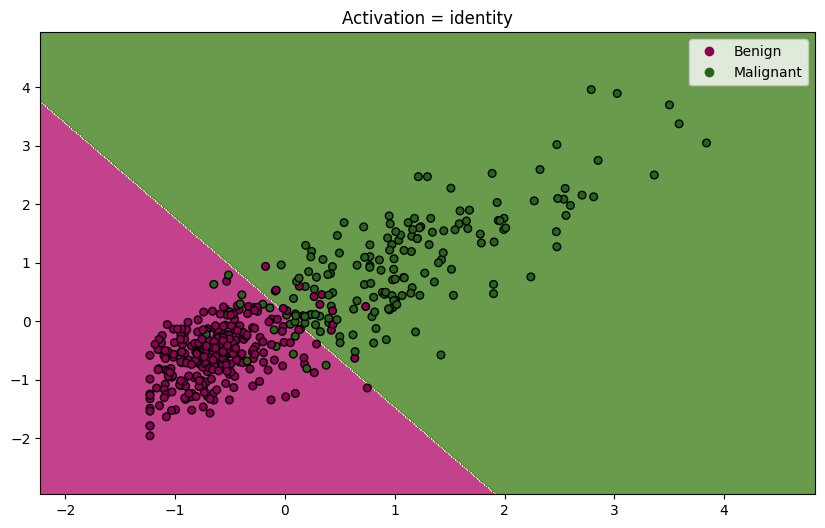

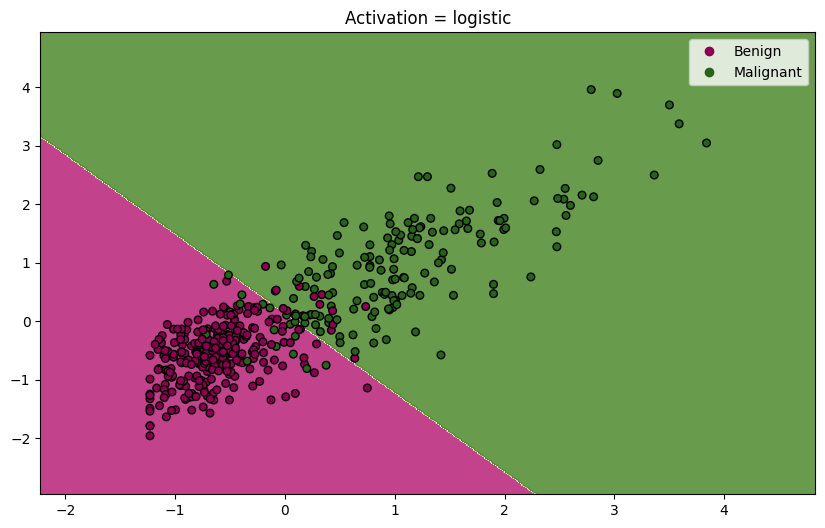

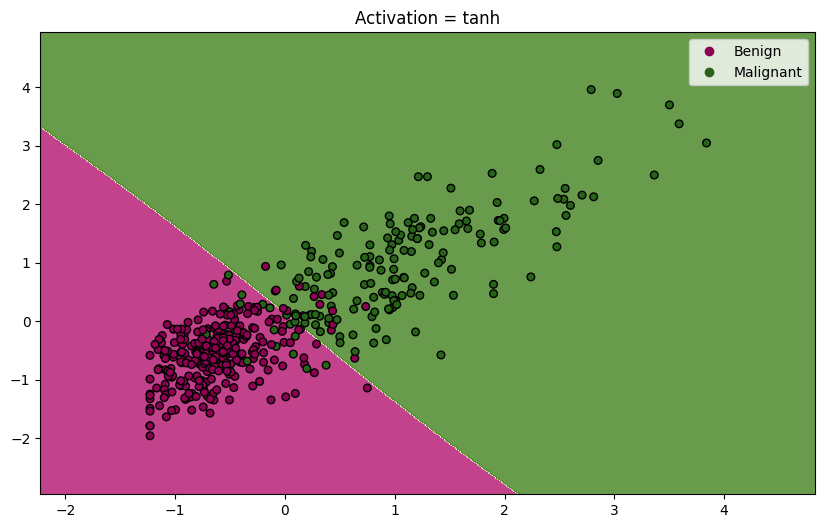

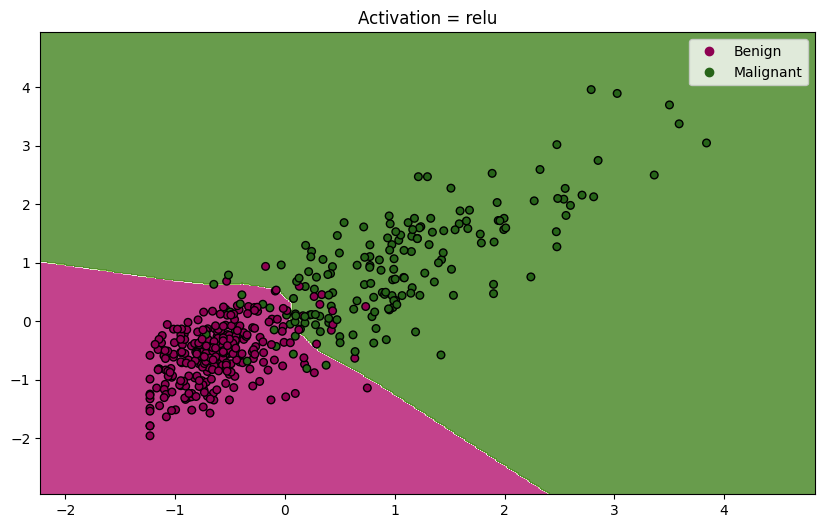

In [18]:
#Example of using 2 hidden layers of 100 units each with varying activations
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

acts  = ['identity', 'logistic', 'tanh', 'relu']
for act in acts:
    mlp = MLPClassifier(hidden_layer_sizes=(100,100), activation = act, max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Activation = {act}")

## Unsupervised learning: PCA

As shown in lecture, PCA is a valuable dimensionality reduction tool that can extract a small subset of valuable features. In this section, we shall demonstrate how PCA can extract important visual features from pictures of subjects faces. We shall use the [AT&T Database of Faces](https://www.kaggle.com/datasets/kasikrit/att-database-of-faces). This dataset contains 40 different subjects with 10 samples per subject which means we a dataset of 400 samples. 

We extract the images from the [scikit-learn dataset library](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces). The library imports the images (faces.data), the flatten array of images (faces.images), and which subject eacj image belongs to (faces.target). Each image is a 64 by 64 image with pixels converted to floating point values in [0,1].

### Eigenfaces

The following codes downloads and loads the face data. 

In [19]:
#Import faces from scikit library
faces = datasets.fetch_olivetti_faces()
print("Flattened Face Data shape:", faces.data.shape)
print("Face Image Data Shape:", faces.images.shape)
print("Shape of target data:", faces.target.shape)


Flattened Face Data shape: (400, 4096)
Face Image Data Shape: (400, 64, 64)
Shape of target data: (400,)


In [20]:
#Extract image shape for future use
im_shape = faces.images[0].shape

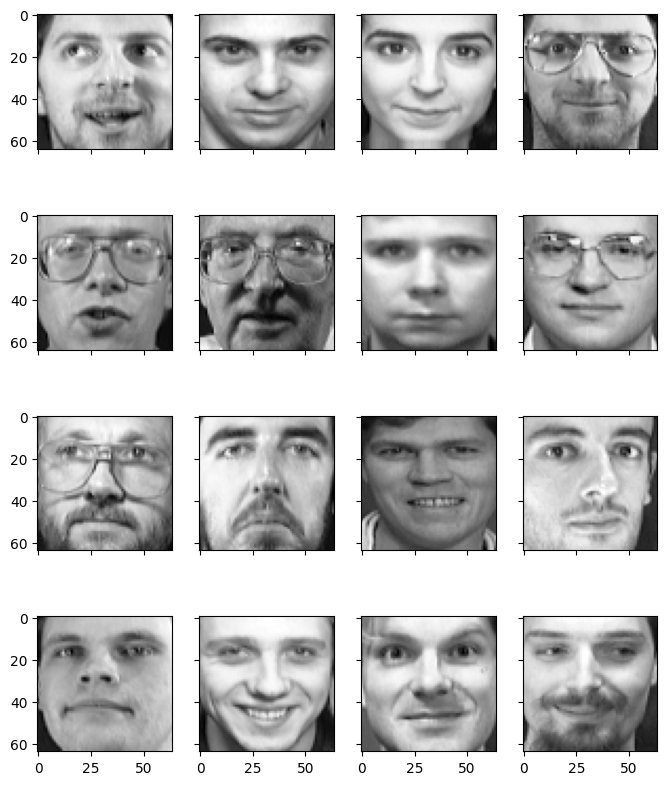

In [21]:
#Prints some example faces 
faceimages = faces.images[np.random.choice(len(faces.images),size= 16, replace = False)] # take random 16 images

fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
plt.show()

Now, let us see what features we can extract from these face images.

In [22]:
#Perform PCA
from sklearn.decomposition import PCA
 
pca = PCA()
pca_pipe = Pipeline([("scaler",StandardScaler()), #Scikit learn PCA does not standardize so we need to add
               ("pca",pca)])
pca_pipe.fit(faces.data)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

The following plots the top 30 PCA components with how much variance does this feature explain.

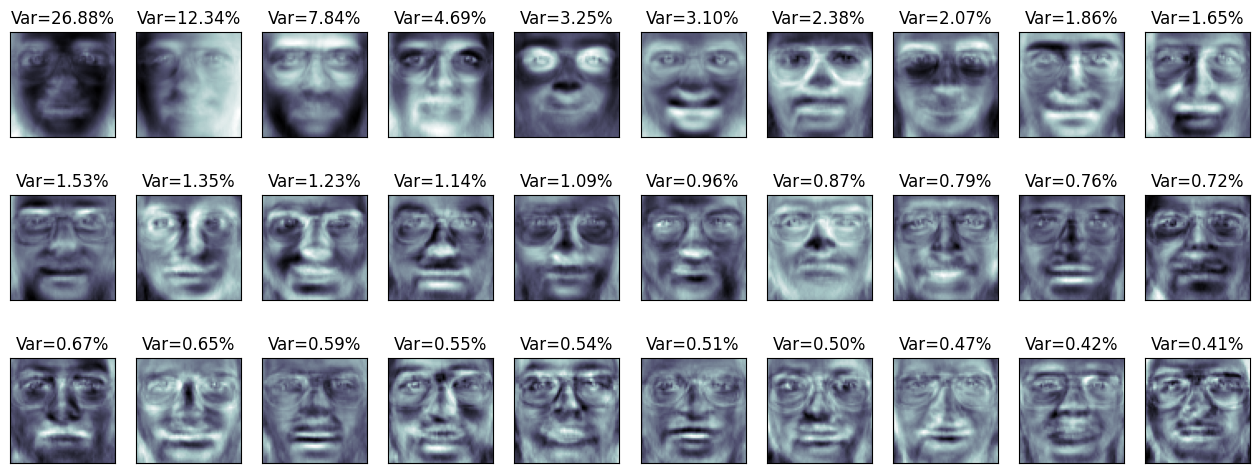

In [23]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(im_shape),
              cmap=plt.cm.bone)
    ax.set_title(f"Var={pca.explained_variance_ratio_[i]:.2%}")

Amazing! We can see that the model has learned to focus on many features that we as humans also look at when trying to identify a face such as the nose,eyes, eyebrows, etc.

With this feature extraction, we can perform much more powerful learning. 

### Feature Extraction for Classification

Lets see if we can use PCA to improve the accuracy of the decision tree classifier.

Accuracy without PCA
Accuracy:    0.894737
Confusion Matrix: 
 [[63  9]
 [ 3 39]]


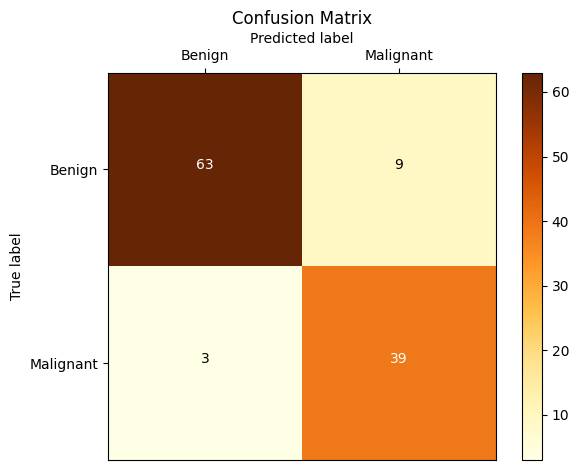

Accuracy with PCA
Accuracy:    0.912281
Confusion Matrix: 
 [[66  6]
 [ 4 38]]


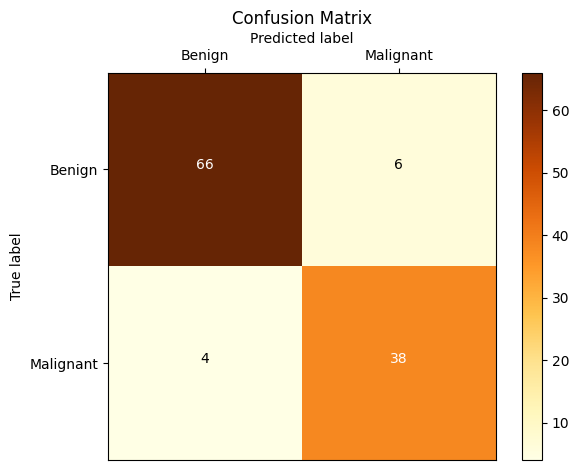

In [24]:
#Without PCA
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train, target)
predicted = clf.predict(test)

print("Accuracy without PCA")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

#With PCA
pca = PCA(n_components = 0.9) #Take components that explain at lest 90% variance
       
train_new = pca.fit_transform(train)
test_new = pca.transform(test)

clf_pca = DecisionTreeClassifier(random_state=0)
clf_pca.fit(train_new, target)
predicted = clf_pca.predict(test_new)

print("Accuracy with PCA")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

In [25]:
print("Number of Features without PCA: ", train.shape[1])
print("Number of Features with PCA: ", train_new.shape[1])

Number of Features without PCA:  20
Number of Features with PCA:  7


Clearly, we get a much better accuracy for the model while using fewer features. But does the features the PCA thought were important the same features that the decision tree used. Lets look at the feature importance of the tree. The following plot numbers the first principal component as 0, the second as 1, and so forth.

<Axes: >

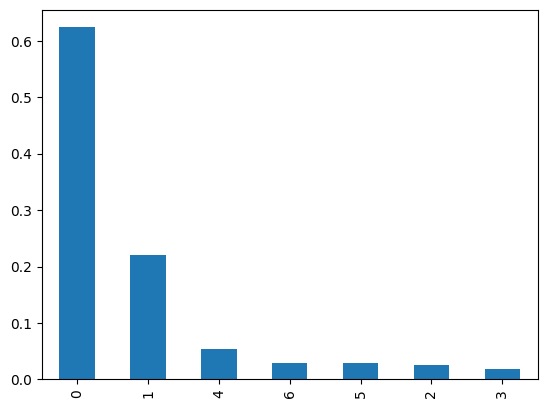

In [26]:
feature_names_new = list(range(train_new.shape[1]))
imp_pd = pd.Series(data = clf_pca.feature_importances_ ,index = feature_names_new)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

Amazingly, the first and second components were the most important features in the decision tree. Thus, we can claim that PCA has significantly improved the performance of our model. 

## Unsupervised learning: Clustering

Clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups. One major algorithm we learned in class is the K-Means algorithm.

### Evaluating K-Means performance

While there are many ways to evaluate the [performance measure of clustering algorithsm](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation), we will focus on the inertia score of the K-Means model. Inertia is another term for the sum of squared distances of samples to their closest cluster center. 

Let us look at how the Inertia changes as a function of the number of clusters for an artificial dataset.


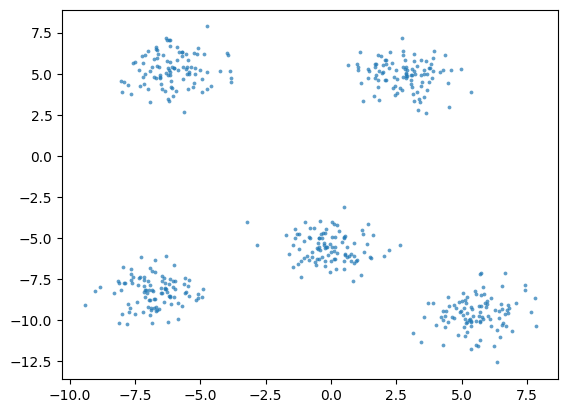

In [27]:
#Artifical Dataset
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=5,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=10,
)  # For reproducibility

plt.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7,edgecolor="k")

In [28]:
ks = list(range(2,10))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans.fit(X)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")

Inertia for K = 2: 13293.997460961546
Inertia for K = 3: 7169.578996856773
Inertia for K = 4: 3247.8674040695832
Inertia for K = 5: 872.8554968701878
Inertia for K = 6: 803.846686425823
Inertia for K = 7: 739.5236191503768
Inertia for K = 8: 690.2530283275607
Inertia for K = 9: 614.5138307338655


/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

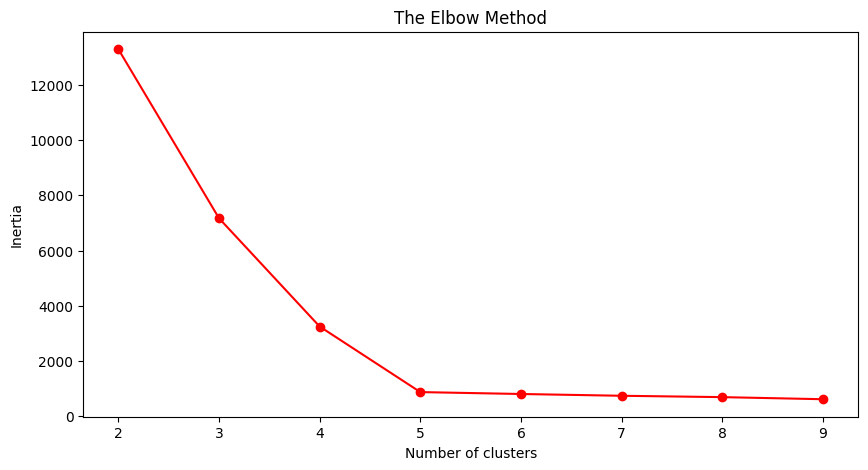

In [29]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

From the plot, we can see that when the number of clusters of K-means is the correct number of clusters, Inertia starts decreasing at a much slower rate. This creates a kind of elbow shape in the graph. For K-means clustering, the elbow method selects the number of clusters where the elbow shape is formed. In this case, we see that this method would produce the correct number of clusters.

Lets try it on the cancer dataset.

In [30]:
ks = list(range(2,30))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans.fit(train)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")

/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

Inertia for K = 2: 6381.278325955922
Inertia for K = 3: 5508.621446593709
Inertia for K = 4: 4972.231721973118
Inertia for K = 5: 4507.26713736607
Inertia for K = 6: 4203.777246823878
Inertia for K = 7: 3942.659550896411
Inertia for K = 8: 3745.1124228292692
Inertia for K = 9: 3532.7225156022073
Inertia for K = 10: 3371.033467027838
Inertia for K = 11: 3232.472758070737
Inertia for K = 12: 3135.1944201924534
Inertia for K = 13: 3033.3838427786477
Inertia for K = 14: 2958.3200036360367


/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

Inertia for K = 15: 2893.798763511904
Inertia for K = 16: 2767.804761705547
Inertia for K = 17: 2737.4747101790635
Inertia for K = 18: 2662.1203080706655
Inertia for K = 19: 2617.90890694005
Inertia for K = 20: 2553.961378449726
Inertia for K = 21: 2491.9133737078346
Inertia for K = 22: 2448.777623600997
Inertia for K = 23: 2391.644588540416
Inertia for K = 24: 2374.1345787190176
Inertia for K = 25: 2334.794010981073
Inertia for K = 26: 2267.993521706617
Inertia for K = 27: 2233.585453239129
Inertia for K = 28: 2191.739402693569
Inertia for K = 29: 2165.254207641313


/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

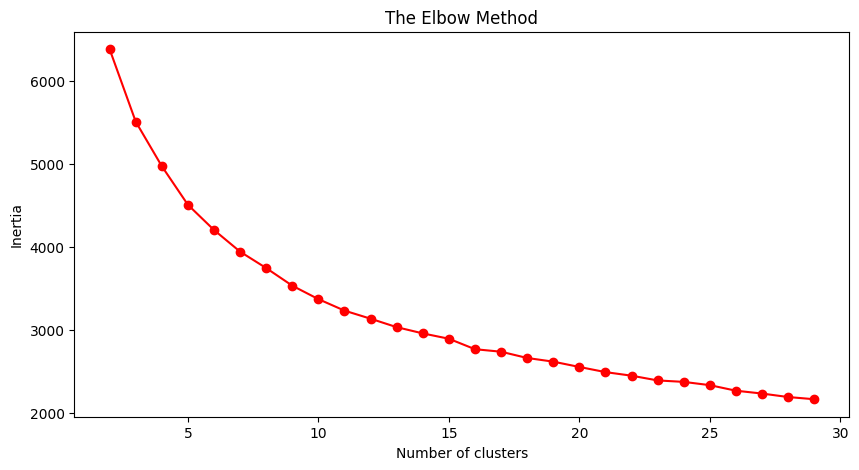

In [31]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Here we see that the elbow is not as cleanly defined. This may be due to the dataset not being a good fit for K-means. Regardless, we can still apply the elbow method by noting that the slow down happens around 7~14.

### Kmeans on Eigenfaces

Now, lets see how K-means performs in clustering the face data with PCA.

In [32]:
from sklearn.cluster import KMeans

n_clusters = 10 #We know there are 10 subjects
km = KMeans(n_clusters  = n_clusters,random_state=0)

pipe= Pipeline([("scaler",StandardScaler()), #First standardize
               ("pca",PCA()), #Transform using pca
         ("kmeans", km )]) #Then apply k means

In [33]:
clusters = pipe.fit_predict(faces.data)
print(clusters)

/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[3 6 3 4 6 4 3 3 3 6 5 5 5 5 5 5 5 5 5 5 1 1 5 1 4 1 4 4 6 6 5 5 5 3 6 4 3
 5 5 6 4 1 1 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 7 7 3 4 7 3 7 7 3 7 0 6 3 6
 3 3 6 3 3 6 1 1 1 4 4 4 4 4 1 6 6 6 6 6 6 6 6 6 4 3 0 0 0 0 0 0 0 0 0 0 4
 1 1 1 1 4 1 6 6 4 5 5 4 4 5 5 4 4 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 8 3 3 3 3 8 6 8 3 3 4 4 1 1 4 4 4 4 4 4 3 6 4 6 3 3 3 3 3 3 7 7 7 7 7
 7 7 7 7 7 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 4 8 9 4 2 2 2 2 2 2 2 2 2 2 3 6
 1 4 1 4 1 6 4 4 8 8 8 8 5 8 8 8 8 8 6 5 6 5 5 5 6 4 5 6 1 1 1 1 1 1 3 1 1
 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 1 4 2 2 2 9 4 4 9 8 2 2 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 7 7 7 7 7 5 7 7 7 9 9 9 9 9 9 9 9 9 9 2 2 2
 2 2 2 2 2 2 2 9 9 9 9 4 6 6 1 4 4 3 8 8 8 7 8 8 8 8 8 1 1 1 1 1 1 1 1 1 1
 4 1 1 6 1 4 6 6 4 1 2 2 2 2 2 2 2 2 2 2 6 4 3 4 3 1 4 1 4 4]


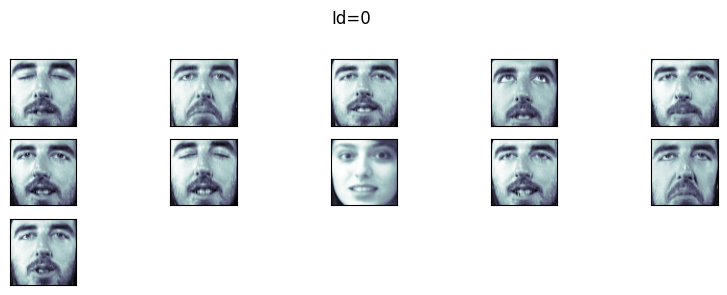

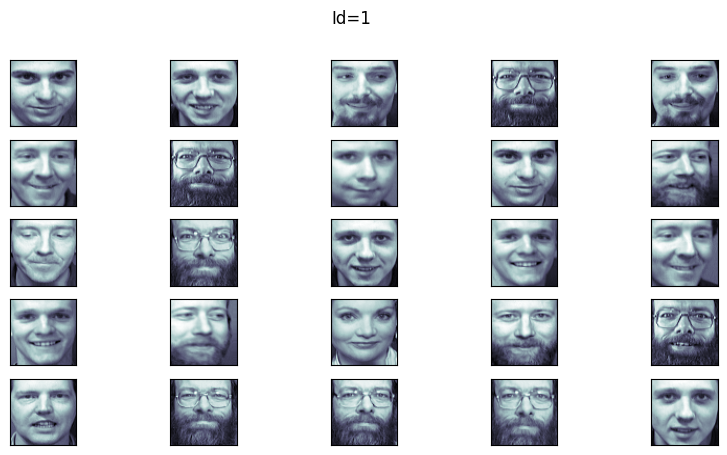

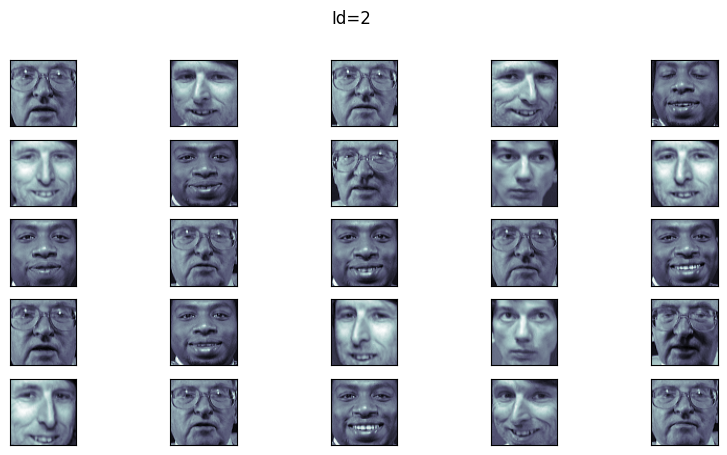

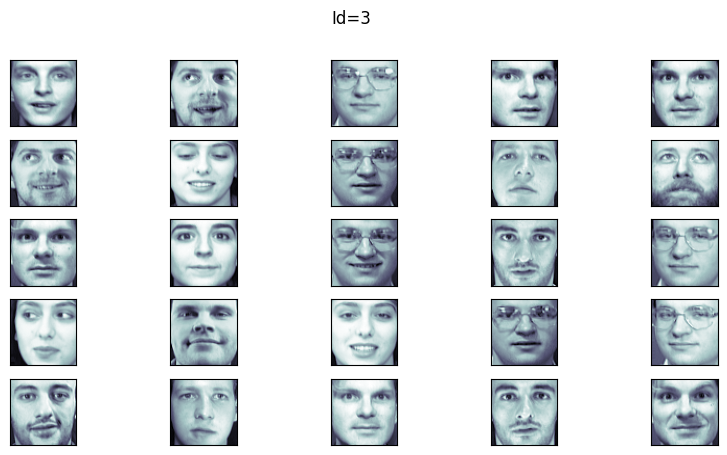

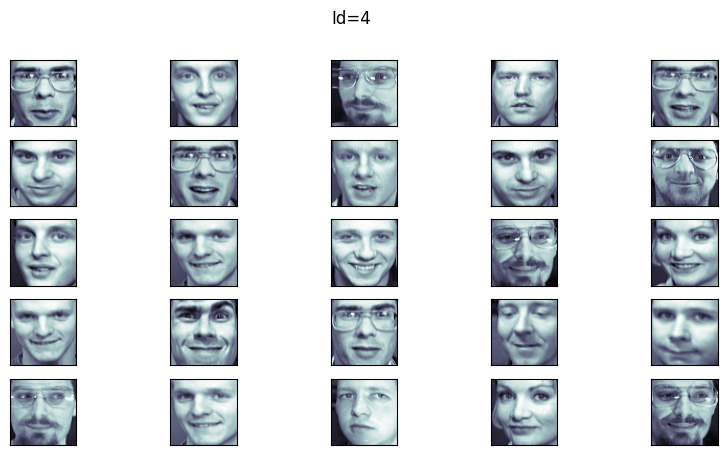

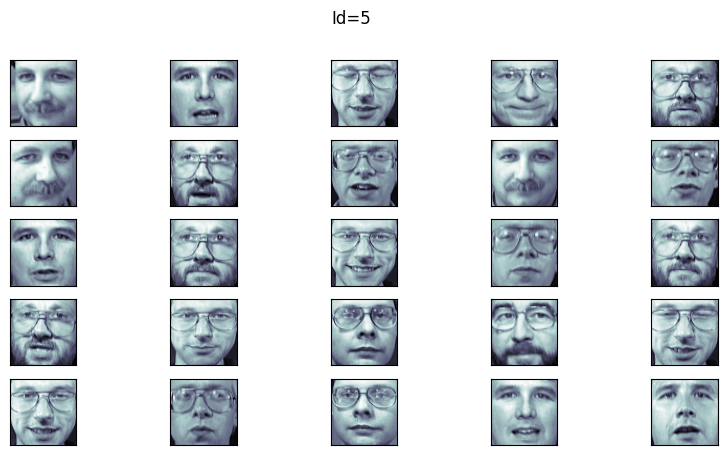

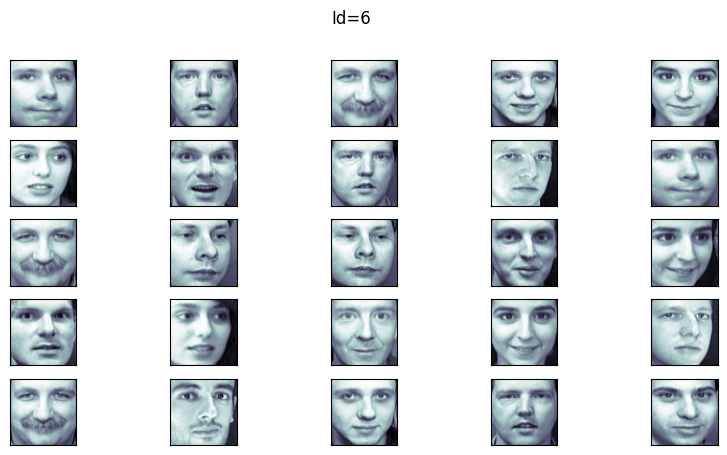

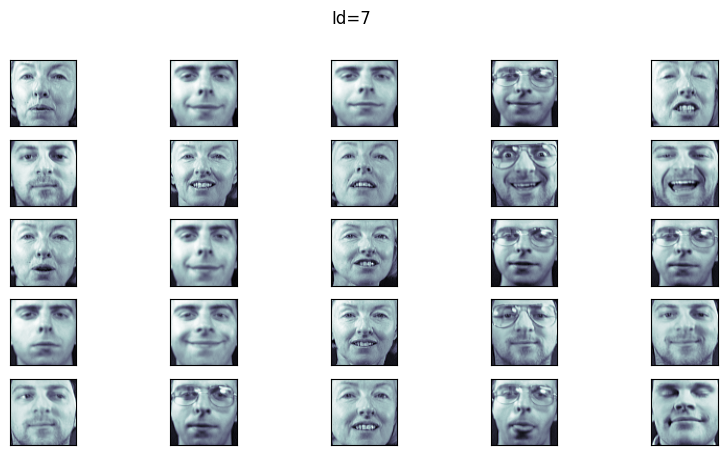

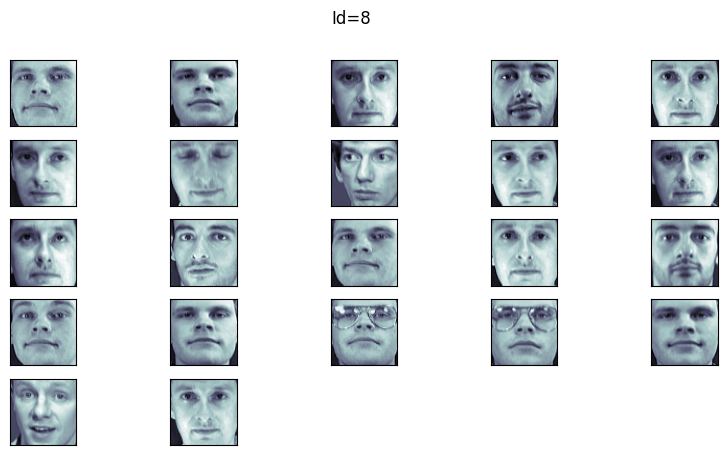

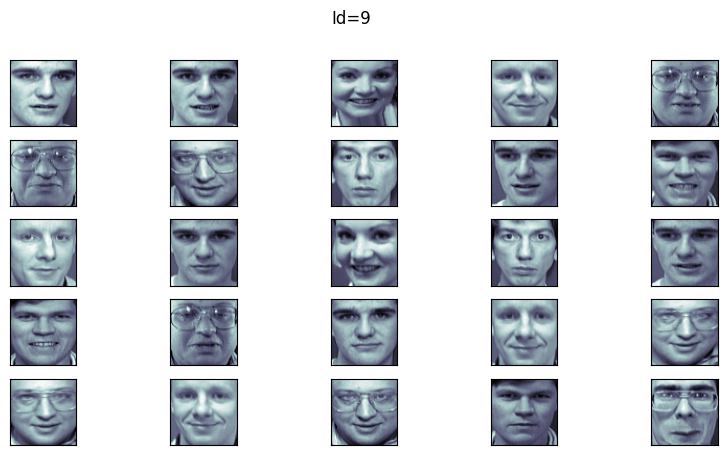

In [34]:
for labelID in range(n_clusters):
    # find all indexes into the `data` array that belong to the
    # current label ID, then randomly sample a maximum of 25 indexes
    # from the set
    idxs = np.where(clusters == labelID)[0]
    idxs = np.random.choice(idxs, size=min(25, len(idxs)),
        replace=False)

    # Extract the sampled indexes
    id_face = faces.images[idxs]

    #Plots sampled faces
    fig = plt.figure(figsize=(10,5))
    for i in range(min(25,len(idxs))):
        ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(id_face[i],
                  cmap=plt.cm.bone)
    fig.suptitle(f"Id={labelID}")

While the algorithm isn't perfect, we can see that K-means with PCA is picking up on some facial similarity or similar expressions. 

# (100 pts) Todo: Use new methods to classify heart disease

To compare how these new models perform with the other models discussed in the course, we will apply these new models on the heart disease dataset that was used in project 2.

## Background: The Dataset (Recap)

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. You will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>chol:</b> cholesterol in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeak:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    

## Preprocess Data

This part is done for you since you would have already completed it in project 2. Use the train, target, test, and target_test for all future parts. We also provide the column names for each transformed column for future use.

In [35]:
#Preprocess Data

#Load Data
data = pd.read_csv('datasets/heartdisease.csv')

#Transform target feature into numerical
le = LabelEncoder() 
data['target'] = le.fit_transform(data['sick'])
data = data.drop(["sick"], axis =1)

#Split target and data
y = data["target"]
x = data.drop(["target"],axis = 1)

#Train test split
#40% in test data as was in project 2
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.4, stratify= y, random_state=0)

#Feature Transformation
#This is the only change from project 2 since we replaced standard scaler to minmax
#This was done to ensure that the numerical features were still of the same scale
#as the one hot encoded features
num_pipeline = Pipeline([
    ('minmax', MinMaxScaler()) 
])

heart_num = train_raw.drop(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca','thal'], axis=1)
numerical_features = list(heart_num)
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca','thal']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", OneHotEncoder(categories='auto'), categorical_features),
])

#Transform raw data 
train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw) #Note that there is no fit calls

#Extracts features names for each transformed column
feature_names = full_pipeline.get_feature_names_out(list(x.columns))

In [36]:
print("Column names after transformation by pipeline: ", feature_names)

Column names after transformation by pipeline:  ['num__age' 'num__trestbps' 'num__chol' 'num__thalach' 'num__oldpeak'
 'cat__sex_0' 'cat__sex_1' 'cat__cp_0' 'cat__cp_1' 'cat__cp_2' 'cat__cp_3'
 'cat__fbs_0' 'cat__fbs_1' 'cat__restecg_0' 'cat__restecg_1'
 'cat__restecg_2' 'cat__exang_0' 'cat__exang_1' 'cat__slope_0'
 'cat__slope_1' 'cat__slope_2' 'cat__ca_0' 'cat__ca_1' 'cat__ca_2'
 'cat__ca_3' 'cat__ca_4' 'cat__thal_0' 'cat__thal_1' 'cat__thal_2'
 'cat__thal_3']


The following shows the baseline accuracy of simply classifying every sample as the majority class.

In [37]:
#Baseline accuracy of using the majority class 
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print("Baseline Accuraccy of using Majority Class: ", np.max(ct)/np.sum(ct))

Counts of each class in target_test: 
0    66
1    56
Name: target, dtype: int64
Baseline Accuraccy of using Majority Class:  0.5409836065573771


## (25 pts) Decision Trees

### [5 pts] Apply  Decision Tree on Train Data

Apply the decision tree on the **train data** with default parameters of the DecisionTreeClassifier. **Report the accuracy and print the confusion matrix**. Make sure to use random_state = 0 so that your results match ours.

Accuracy:    0.696721
Confusion Matrix: 
 [[53 13]
 [24 32]]


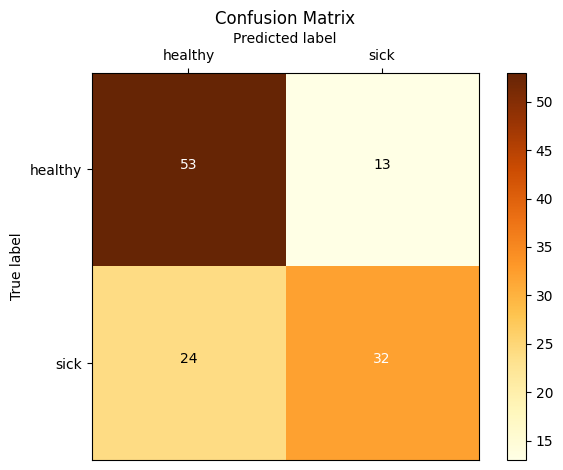

In [38]:
clf = DecisionTreeClassifier(random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

### [5 pts] Visualize the Decision Tree

Visualize the first two layers of the decision tree that you trained.

[Text(0.4230769230769231, 0.875, 'cat__cp_0 <= 0.5\ngini = 0.496\nsamples = 100.0%\nvalue = [0.547, 0.453]'),
 Text(0.15384615384615385, 0.625, 'num__chol <= 0.223\ngini = 0.283\nsamples = 48.6%\nvalue = [0.83, 0.17]'),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 18.2%\nvalue = [1.0, 0.0]'),
 Text(0.23076923076923078, 0.375, 'cat__slope_2 <= 0.5\ngini = 0.397\nsamples = 30.4%\nvalue = [0.727, 0.273]'),
 Text(0.15384615384615385, 0.125, '\n  (...)  \n'),
 Text(0.3076923076923077, 0.125, '\n  (...)  \n'),
 Text(0.6923076923076923, 0.625, 'cat__ca_0 <= 0.5\ngini = 0.403\nsamples = 51.4%\nvalue = [0.28, 0.72]'),
 Text(0.5384615384615384, 0.375, 'cat__exang_1 <= 0.5\ngini = 0.115\nsamples = 27.1%\nvalue = [0.061, 0.939]'),
 Text(0.46153846153846156, 0.125, '\n  (...)  \n'),
 Text(0.6153846153846154, 0.125, '\n  (...)  \n'),
 Text(0.8461538461538461, 0.375, 'cat__thal_3 <= 0.5\ngini = 0.499\nsamples = 24.3%\nvalue = [0.523, 0.477]'),
 Text(0.7692307692307693, 0.125, '\n  (...)  

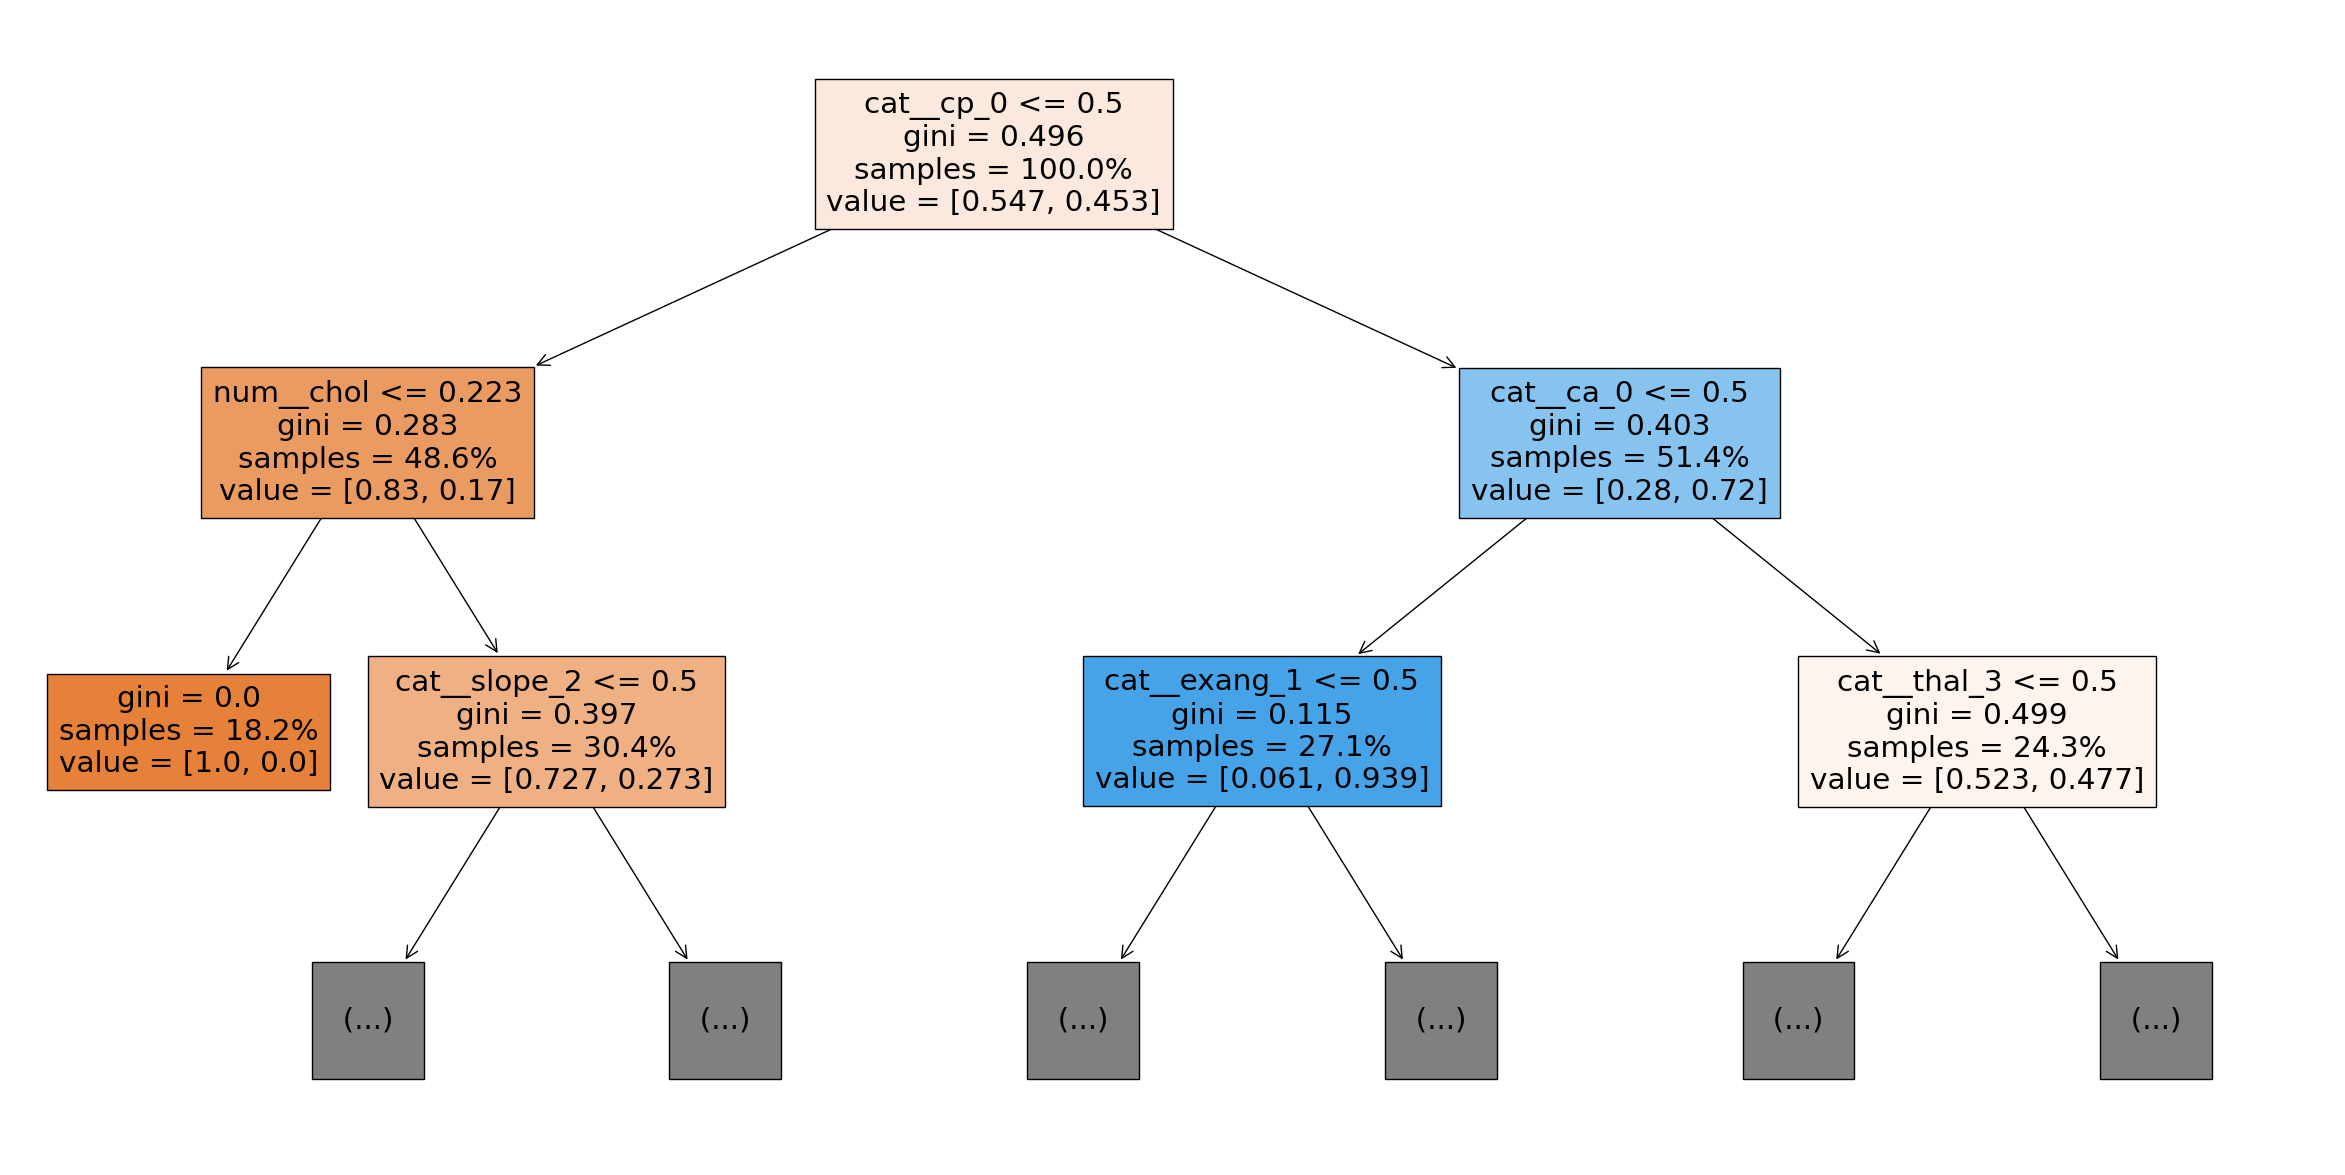

In [39]:
plt.figure(figsize = (30,15)) 
tree.plot_tree(clf,max_depth=2, proportion=True,feature_names=feature_names, filled=True)

**What is the gini index improvement of the first split?**

Response: 0.15132

### [5 pts] Plot the importance of each feature for the Decision Tree

<Axes: >

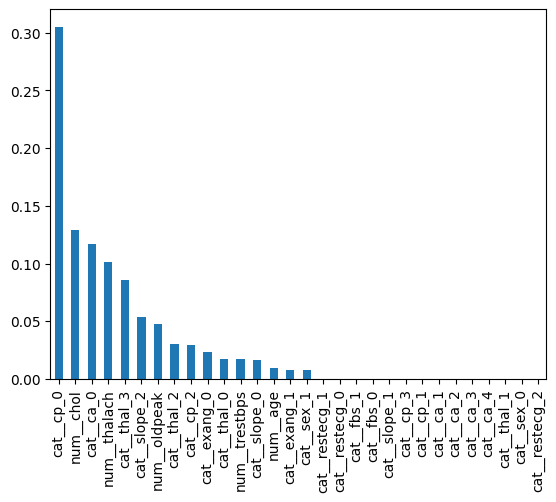

In [40]:
imp_pd = pd.Series(data = clf.feature_importances_ ,index = feature_names)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

**How many features have non-zero importance for the Decision Tree? If we remove the features with zero importance, will it change the decision tree for the same sampled dataset?** 

Response: There are 16 features with non-zero importance. Removing the features with zero importance will not change the decision tree.

### [10 pts] Optimize Decision Tree

While the default Decision Tree performs fairly well on the data, lets see if we can improve performance by optimizing the parameters.

Run a GridSearchCV with 3-Fold Cross Validation for the Decision Tree. Find the best model parameters amongst the following:

- max_depth = [1,2,3,4,5,10,15]
- min_samples_split = [2,4,6,8]
- criterion = ["gini", "entropy"]

After using GridSearchCV, print the best model parameters and the best score.

In [41]:
k = 3
kf = KFold(n_splits=k, random_state=None)

parameters = [
    {"max_depth": [1,2,3,4,5,10,15],
    "min_samples_split": [2,4,6,8],
    "criterion": ["gini", "entropy"]}
]

clf = DecisionTreeClassifier(random_state = 0)

grid = GridSearchCV(clf, parameters, cv = kf, scoring = "accuracy")
grid.fit(train,target)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5, 10, 15],
                          'min_samples_split': [2, 4, 6, 8]}],
             scoring='accuracy')

In [42]:
res= pd.DataFrame(grid.cv_results_)
res.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.002892      0.003409         0.000307        0.000172   
1       0.000452      0.000046         0.000181        0.000003   
2       0.000393      0.000015         0.000169        0.000007   
3       0.000369      0.000010         0.000163        0.000005   
4       0.000418      0.000010         0.000166        0.000002   

  param_criterion param_max_depth param_min_samples_split  \
0            gini               1                       2   
1            gini               1                       4   
2            gini               1                       6   
3            gini               1                       8   
4            gini               2                       2   

                                              params  split0_test_score  \
0  {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.754098   
1  {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.754098   
2  {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.754098   
3  {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.754098   
4  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.704918   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.766667           0.750000         0.756922        0.007091   
1           0.766667           0.750000         0.756922        0.007091   
2           0.766667           0.750000         0.756922        0.007091   
3           0.766667           0.750000         0.756922        0.007091   
4           0.716667           0.783333         0.734973        0.034531   

   rank_test_score  
0               12  
1               12  
2               12  
3               12  
4               42

In [43]:
best_model = grid.best_params_
best_score = grid.best_score_

print(f"Best model: {best_model}")
print(f"Best score: {best_score}")

Best model: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 8}
Best score: 0.7681238615664846


**Using the best model you have, report the test accuracy and print out the confusion matrix**

Accuracy:    0.745902
Confusion Matrix: 
 [[55 11]
 [20 36]]


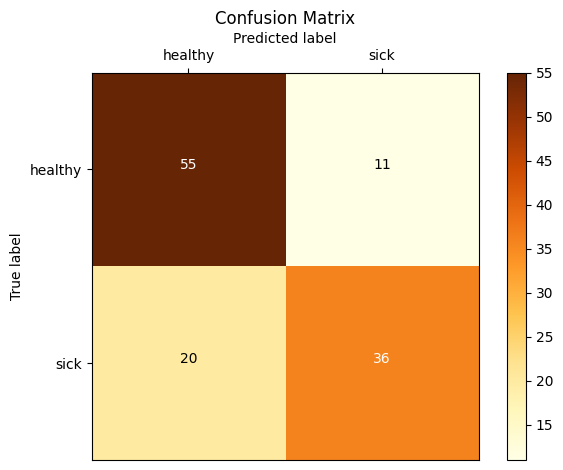

In [44]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, min_samples_split = 8)
clf.fit(train, target)
predicted = clf.predict(test)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

## (20 pts) Multi-Layer Perceptron

### [5 pts] Applying a Multi-Layer Perceptron
Apply the MLP on the **train data** with hidden_layer_sizes=(100,100) and max_iter = 800. **Report the accuracy and print the confusion matrix**. Make sure to set random_state=0. 

In [45]:
clf = MLPClassifier(hidden_layer_sizes=(100,100), max_iter = 800, random_state=0)
clf.fit(train, target)
predicted = clf.predict(test)

Accuracy:    0.819672
Confusion Matrix: 
 [[63  3]
 [19 37]]


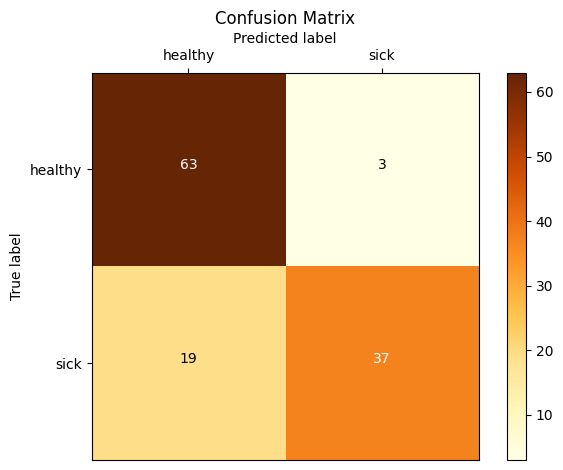

In [46]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

### [10 pts] Speedtest between Decision Tree and MLP

Let us compare the training times and prediction times of a Decision Tree and an MLP. **Time how long it takes for a Decision Tree and an MLP to perform a .fit operation (i.e. training the model). Then, time how long it takes for a Decision Tree and an MLP to perform a .predict operation (i.e. predicting the testing data). Print out the timings and specify which model was quicker for each operation.** We recommend using the [time](https://docs.python.org/3/library/time.html) python module to time your code. 
An example of the time module was shown in project 2. Use the default Decision Tree Classifier and the MLP with the previously mentioned parameters.

In [47]:

dct = DecisionTreeClassifier(random_state = 0)
mlp = MLPClassifier(hidden_layer_sizes=(100,100), max_iter = 800, random_state=0)

t0 = time.time()
dct.fit(train, target)
t1 = time.time()
dct_train_time = t1-t0
print("DecisionTreeClassifier Training Time : ", dct_train_time)

t0 = time.time()
mlp.fit(train, target)
t1 = time.time()
mlp_train_time = t1-t0
print("MLPClassifier Training Time : ", mlp_train_time)

DecisionTreeClassifier Training Time :  0.0018420219421386719
MLPClassifier Training Time :  0.9859609603881836


In [48]:
t0 = time.time()
dct.predict(test)
t1 = time.time()
dct_test_time = t1-t0
print("DecisionTreeClassifier Testing Time : ", dct_test_time)

t0 = time.time()
mlp.predict(test)
t1 = time.time()
mlp_test_time = t1-t0
print("MLPClassifier Testing Time : ", mlp_test_time)

DecisionTreeClassifier Testing Time :  0.00020003318786621094
MLPClassifier Testing Time :  0.007932186126708984


In [49]:
if (dct_test_time>mlp_test_time):
    print("MLP operates quicker for .predict operation")
elif(dct_test_time<mlp_test_time):
    print("Decision tree operates quicker for .predict operation")
else:
    print("They have the same speed when implementing .predict operation")


Decision tree operates quicker for .predict operation


### [5 pts] Compare and contrast Decision Trees and MLPs.

**Describe at least one advantage and disadvantage of using an MLP over a Decision Tree.**

Response:

Advantage: 
1. MLPs have the ability to learn and model non-linear and complex relationships

Disadvantage:
1. MLPs takes longer time to train and predict

## (35 pts) PCA

### [5 pts] Transform the train data using PCA

Train a PCA model to project the train data on the top 10 components. **Print out the 10 principal components**. Look at the documentation of [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for reference.

In [50]:
pca=PCA(n_components=10)
pca.fit_transform(train)
for i in range(10):
    print(pca.components_[i])

[ 0.06099466  0.04034864  0.01924581 -0.1017322   0.11071541 -0.12331434
  0.12331434  0.34265332 -0.13458918 -0.20936122  0.00129708 -0.01288493
  0.01288493  0.19693729 -0.19855631  0.00161902 -0.35054419  0.35054419
  0.04595587  0.29412324 -0.34007911 -0.20553518  0.07463263  0.08348053
  0.06758334 -0.02016132 -0.00039038  0.04438528 -0.31408112  0.27008622]
[ 0.05231789  0.02890251  0.03826504 -0.00733246 -0.0037285   0.44442215
 -0.44442215  0.07362246 -0.03171478 -0.02860787 -0.01329982 -0.02106535
  0.02106535  0.42589374 -0.44447634  0.0185826   0.0184908  -0.0184908
 -0.02183111  0.1435457  -0.1217146   0.02011775 -0.03199655  0.03699266
  0.00382438 -0.02893824  0.00336806  0.00301279  0.29007107 -0.29645192]
[-0.0427616  -0.03742143  0.00354063 -0.04733566  0.01801283  0.30699875
 -0.30699875  0.09347247  0.0329172  -0.0989118  -0.02747786  0.19990151
 -0.19990151 -0.43118048  0.40996579  0.0212147  -0.13223456  0.13223456
 -0.02514842  0.32090865 -0.29576023  0.29149476 -

### [5 pts] Percentage of variance explained by top 10 principal components

Using PCA's "explained_variance_ratio_", print the percentage of variance explained by the top 10 principal components.

In [51]:
for i in range(10):
    print('{:.1%}'.format(pca.explained_variance_ratio_[i]))

23.9%
13.6%
10.0%
8.2%
7.5%
6.6%
5.9%
4.9%
4.0%
3.0%


### [5 pts] Transform the train and test data into train_pca and test_pca using PCA

Note: Use fit_transform for train and transform for test

In [52]:
train_pca=pca.fit_transform(train)
test_pca=pca.transform(test)

### [5 pts] PCA+Decision Tree

Train the default Decision Tree Classifier using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

Accuracy with PCA
Accuracy:    0.762295
Confusion Matrix: 
 [[53 13]
 [16 40]]


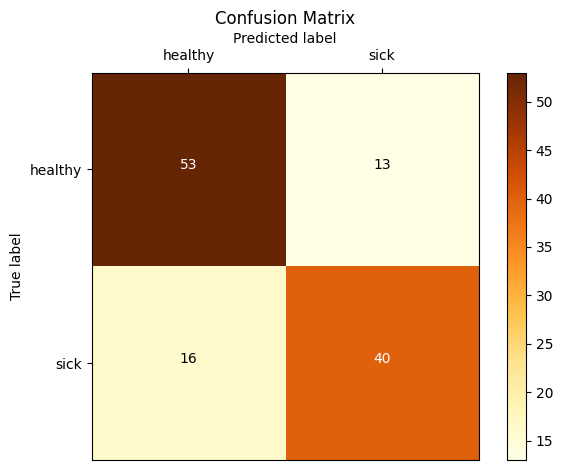

In [53]:
clf_pca = DecisionTreeClassifier(random_state=0)
clf_pca.fit(train_pca, target)
predicted = clf_pca.predict(test_pca)

print("Accuracy with PCA")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

**Does the model perform better with or without PCA?**

Response:

No, it performs better without PCA

### [5 pts] PCA+MLP

Train the MLP classifier with the same parameters as before using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

Accuracy:    0.803279
Confusion Matrix: 
 [[61  5]
 [19 37]]


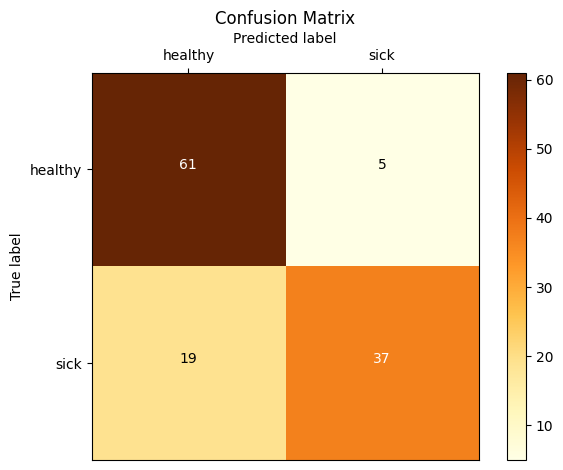

In [54]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100), max_iter = 800)
mlp.fit(train_pca, target)
predicted = mlp.predict(test_pca)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

**Does the model perform better with or without PCA?**

Response:

No, it performs better withour PCA.

### [10 pts] Pros and Cons of PCA

**In your own words, provide at least two pros and at least two cons for using PCA**

Response:

Pros:
- If we have correlated features, PCA can help in reducing the dimensions by removing some of the redundant features, making computations more efficient.
- By reducing variables, we can reduce the risk of over-fitting.

Cons:
- Downscaling via PCA may lead to information loss.
- The effect of PCA is limited if the features are already uncorrelated.

## (20 pts) K-Means Clustering

### [5 pts] Apply K-means to the train data and print out the Inertia score

Use n_cluster = 5 and random_state = 0.

In [55]:
kmeans = KMeans(n_clusters = 5, random_state = 0)
kmeans.fit(train)
print(f"Inertia for K = 5: {kmeans.inertia_}")

Inertia for K = 5: 491.0665663612592


/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### [10 pts] Find the optimal cluster size using the elbow method. 

Use the elbow method to find the best cluster size or range of best cluster sizes for the train data. Check the cluster sizes from 2 to 20. Make sure to plot the Inertia and state where you think the elbow starts. Make sure to use random_state = 0.

In [56]:
ks = list(range(2,20))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(train)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")

Inertia for K = 2: 619.2596852490838
Inertia for K = 3: 562.2941749488493
Inertia for K = 4: 515.3501104402982
Inertia for K = 5: 491.0665663612592
Inertia for K = 6: 458.3449062857246
Inertia for K = 7: 436.46731311592123
Inertia for K = 8: 427.64243132453544
Inertia for K = 9: 409.3453854307658
Inertia for K = 10: 393.8362013824142
Inertia for K = 11: 375.627142914177
Inertia for K = 12: 366.872574191804
Inertia for K = 13: 356.0704428612708
Inertia for K = 14: 353.0506627827143
Inertia for K = 15: 342.96648926542787
Inertia for K = 16: 335.8288846772815
Inertia for K = 17: 325.33654094415067
Inertia for K = 18: 310.3448076066395
Inertia for K = 19: 306.7095752890683


/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

## Answer:
I think the elbow starts at around 13

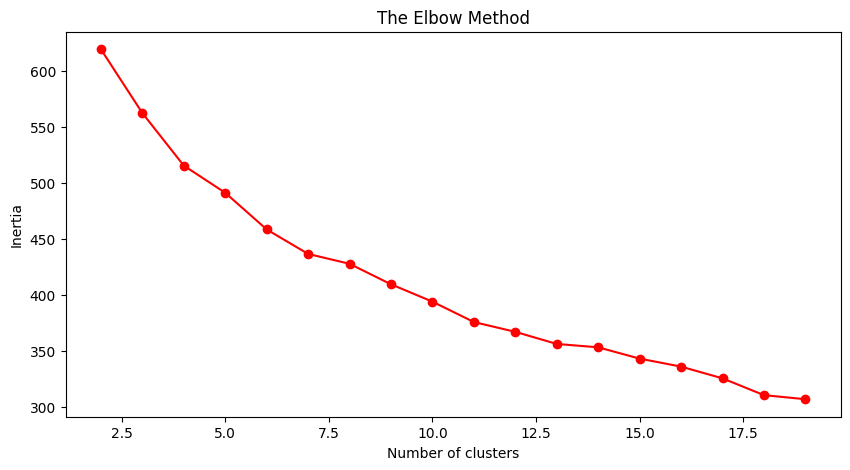

In [57]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

### [5 pts] Find the optimal cluster size for the train_pca data
 
Repeat the same experiment but use train_pca instead of train. 

In [58]:
ks = list(range(2,20))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(train_pca)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")

Inertia for K = 2: 526.8986473659897
Inertia for K = 3: 469.48656326630123
Inertia for K = 4: 423.21611352039656
Inertia for K = 5: 403.5879123750672
Inertia for K = 6: 371.07845721489133
Inertia for K = 7: 350.3642628743978
Inertia for K = 8: 330.0476150629753
Inertia for K = 9: 314.6918920164625
Inertia for K = 10: 298.74474399366363
Inertia for K = 11: 288.50442948032435
Inertia for K = 12: 277.35479695139963
Inertia for K = 13: 266.20679282269043
Inertia for K = 14: 258.12394695638227
Inertia for K = 15: 250.34211491204914
Inertia for K = 16: 234.4644598949217
Inertia for K = 17: 231.1757025955667
Inertia for K = 18: 221.78373427947037
Inertia for K = 19: 220.04830474526787


/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tonyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

**Notice that the inertia is much smaller for every cluster size when using PCA features. Why do you think this is happening? Hint: Think about what Inertia is calculating and consider the number of features that PCA outputs.**

Response: 

Inertia measures the sum of squared distances to the nearest cluster center. PCA reduces the dimensionality and condenses the data, which in turn reduces the Euclidean distance and thus the inertia. This is why there is less inertia when using PCA features.

# (100 pts) Putting it all together

Through all the homeworks and projects, you have learned how to apply many different models to perform a supervised learning task. We are now asking you to take everything that you learned to create a model that can predict whether a hotel reservation will be canceled or not.


**Context**

Hotels see millions of people every year and always wants to keep rooms occupied and payed for. Cancellations make the business lose money since it may make it difficult to reserve to another customer on such short notice. As such, it is useful for a hotel to know whether a reservation is likely to cancel or not. The following dataset will provide a variety of information about a booking that you will use to predict whether that booking will cancel or not. 


Property Management System - PMS

**Attribute Information**

(C) is for Categorical 

(N) is for Numeric

    1) is_canceled (C) : Value indicating if the booking was canceled (1) or not (0).
    2) hotel (C) : The datasets contains the booking information of two hotel. One of the hotels is a resort hotel and the other is a city hotel.
    3) arrival_date_month (C): Month of arrival date with 12 categories: “January” to “December”
    4) stays_in_weekend_nights (N): Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
    5) stays_in_week_nights (N): Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel BO and BL/Calculated by counting the number of week nights
    6) adults (N): Number of adults
    7) children (N): Number of children
    8) babies (N): Number of babies
    9) meal (C): Type of meal
    10) country (C): Country of origin.
    11) previous_cancellations (N): Number of previous bookings that were canceled by the customer prior to the current booking
    12) previous_bookings_not_canceled (N) : Number of previous bookings not canceled by the customer prior to the current booking
    13) reserved_room_type (C): Code of room type reserved. Code is presented instead of designation for anonymity reasons
    14) booking_changes (N) : Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
    15) deposit_type (C) : No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay
    16) days_in_waiting_list (N): Number of days the booking was in the waiting list before it was confirmed to the customer
    17) customer_type (C): Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking
    18) adr (N): Average Daily Rate (Calculated by dividing the sum of all lodging transactions by the total number of staying nights)
    19) required_car_parking_spaces (N): Number of car parking spaces required by the customer
    20) total_of_special_requests (N): Number of special requests made by the customer (e.g. twin bed or high floor)
    21) name (C): Name of the Guest (Not Real)
    22) email (C): Email (Not Real)
    23) phone-number (C): Phone number (not real)

This dataset is quite large with 86989 samples. This makes it difficult to just brute force running a lot of models. As such, you have to be thoughtful when designing your models.

The file name for the training data is "hotel_booking.csv".

**Challenge**

This project is about being able to predict whether a reservation is likely to cancel based on the
input parameters available to us. We will ask you to perform some specific instructions to lead you in the right direction but you are given free reign on which models to use and the preprocessing steps you make. We will ask you to **write out a description of what models you choose and why you choose them**.

## (50 pts) Preprocessing


**Preprocessing:**
For the dataset, the following are mandatory pre-processing steps for your data:

- Use One-Hot Encoding on all categorical features (specify whether you keep the extra feature or not for features with multiple values)
- Determine which fields need to be dropped
- Handle missing values (Specify your strategy)
- Rescale the real valued features using any strategy you choose (StandardScaler, MinMaxScaler, Normalizer, etc)
- Augment at least one feature
- Implement a train-test split with 20% of the data going to the test data. Make sure that the test and train data are balanced in terms of the desired class.


After writing your preprocessing code, write out a description of what you did for each step and provide a justification for your choices. All descriptions should be written in the markdown cells of the jupyter notebook. Make sure your writing is clear and professional.  

We highly recommend reading through the [scikit-learn documentation](https://scikit-learn.org/stable/data_transforms.html) to make this part easier.

### - Helper functions

In [57]:
from sklearn.svm import SVC  #SVM classifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

def print_confusionMatrix_info(target_test, predicted):
    print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
    print("%-12s %f" % ('Precision:', metrics.precision_score(target_test,predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
    print("%-12s %f" % ('Recall:', metrics.recall_score(target_test,predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
    print("%-12s %f" % ('F1 Score:', metrics.f1_score(target_test,predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
    print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))


def print_confusionMatrix_info_pca(target_test, predicted):
    print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
    print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))

#### - Load the dataset: datasets/hotel_booking.csv

In [58]:
data = pd.read_csv('datasets/hotel_booking.csv')

#### - Take a closer look at the dataset we're working with. Use the head method,  the describe method, and the info method to display some of the rows

In [59]:
data.head()

is_canceled         hotel  lead_time arrival_date_month  \
0            0  Resort Hotel          4           February   
1            1    City Hotel        172               June   
2            0    City Hotel          4           November   
3            1    City Hotel         68          September   
4            1    City Hotel        149               July   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        1                     2       2       0.0       0   
1                        0                     2       1       0.0       0   
2                        2                     1       1       0.0       0   
3                        0                     2       2       0.0       0   
4                        2                     4       3       0.0       0   

  meal  ... booking_changes  deposit_type  days_in_waiting_list  \
0   FB  ...               0    No Deposit                     0   
1   BB  ...               0    No Deposit                     0   
2   BB  ...               0    No Deposit                     0   
3   HB  ...               0    No Deposit                     0   
4   BB  ...               0    No Deposit                     0   

     customer_type    adr required_car_parking_spaces  \
0        Transient   75.0                           0   
1  Transient-Party   95.0                           0   
2        Transient   65.0                           0   
3  Transient-Party    0.0                           0   
4        Transient  167.7                           0   

   total_of_special_requests             name                         email  \
0                          1      Linda Moore                LMoore@att.com   
1                          0   Madison Greene  Greene_Madison56@verizon.com   
2                          0  Alicia Richards   Richards.Alicia@comcast.net   
3                          0    Gregory Smith      GregorySmith@outlook.com   
4                          0  Rachel Martinez          Rachel.M@outlook.com   

   phone-number  
0  217-602-3707  
1  791-162-2669  
2  442-385-2754  
3  670-687-2703  
4  692-194-2274  

[5 rows x 24 columns]

In [60]:
data.describe()

is_canceled     lead_time  stays_in_weekend_nights  \
count  78290.000000  78290.000000             78290.000000   
mean       0.405812    109.260135                 0.882156   
std        0.491052    113.690202                 0.986962   
min        0.000000      0.000000                 0.000000   
25%        0.000000     17.000000                 0.000000   
50%        0.000000     71.000000                 1.000000   
75%        1.000000    169.000000                 2.000000   
max        1.000000    737.000000                16.000000   

       stays_in_week_nights        adults      children        babies  \
count          78290.000000  78290.000000  78287.000000  78290.000000   
mean               2.437910      1.838958      0.089312      0.008673   
std                1.864397      0.615962      0.369761      0.104877   
min                0.000000      0.000000      0.000000      0.000000   
25%                1.000000      2.000000      0.000000      0.000000   
50%                2.000000      2.000000      0.000000      0.000000   
75%                3.000000      2.000000      0.000000      0.000000   
max               41.000000     55.000000     10.000000     10.000000   

       previous_cancellations  previous_bookings_not_canceled  \
count            78290.000000                    78290.000000   
mean                 0.108698                        0.174646   
std                  0.885138                        1.738073   
min                  0.000000                        0.000000   
25%                  0.000000                        0.000000   
50%                  0.000000                        0.000000   
75%                  0.000000                        0.000000   
max                 26.000000                       72.000000   

       booking_changes  days_in_waiting_list           adr  \
count     78290.000000          78290.000000  78290.000000   
mean          0.202286              2.863150     98.154606   
std           0.596063             19.670393     51.826966   
min           0.000000              0.000000     -6.380000   
25%           0.000000              0.000000     65.000000   
50%           0.000000              0.000000     90.000000   
75%           0.000000              0.000000    120.000000   
max          20.000000            391.000000   5400.000000   

       required_car_parking_spaces  total_of_special_requests  
count                 78290.000000               78290.000000  
mean                      0.065104                   0.510001  
std                       0.248054                   0.768116  
min                       0.000000                   0.000000  
25%                       0.000000                   0.000000  
50%                       0.000000                   0.000000  
75%                       0.000000                   1.000000  
max                       3.000000                   5.000000

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78290 entries, 0 to 78289
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     78290 non-null  int64  
 1   hotel                           78290 non-null  object 
 2   lead_time                       78290 non-null  int64  
 3   arrival_date_month              78290 non-null  object 
 4   stays_in_weekend_nights         78290 non-null  int64  
 5   stays_in_week_nights            78290 non-null  int64  
 6   adults                          78290 non-null  int64  
 7   children                        78287 non-null  float64
 8   babies                          78290 non-null  int64  
 9   meal                            78290 non-null  object 
 10  country                         78290 non-null  object 
 11  previous_cancellations          78290 non-null  int64  
 12  previous_bookings_not_canceled  

In [62]:
print(data.nunique())

is_canceled                           2
hotel                                 2
lead_time                           479
arrival_date_month                   12
stays_in_weekend_nights              14
stays_in_week_nights                 30
adults                               14
children                              5
babies                                5
meal                                  5
country                               5
previous_cancellations               14
previous_bookings_not_canceled       69
reserved_room_type                   10
booking_changes                      16
deposit_type                          3
days_in_waiting_list                120
customer_type                         4
adr                                6730
required_car_parking_spaces           4
total_of_special_requests             6
name                              58254
email                             76680
phone-number                      78290
dtype: int64


#### - Determine if we're dealing with any null values. 

In [63]:
data.isnull().sum()

is_canceled                       0
hotel                             0
lead_time                         0
arrival_date_month                0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          3
babies                            0
meal                              0
country                           0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
name                              0
email                             0
phone-number                      0
dtype: int64

#### - Handle missing values

Due to the dataset's sufficient size, three missing values in the "children" variable can be safely dropped without affecting accuracy.


In [64]:
data = data.dropna()

#### - Plotting histogram of data

array([[<Axes: title={'center': 'is_canceled'}>,
        <Axes: title={'center': 'lead_time'}>,
        <Axes: title={'center': 'stays_in_weekend_nights'}>,
        <Axes: title={'center': 'stays_in_week_nights'}>],
       [<Axes: title={'center': 'adults'}>,
        <Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'babies'}>,
        <Axes: title={'center': 'previous_cancellations'}>],
       [<Axes: title={'center': 'previous_bookings_not_canceled'}>,
        <Axes: title={'center': 'booking_changes'}>,
        <Axes: title={'center': 'days_in_waiting_list'}>,
        <Axes: title={'center': 'adr'}>],
       [<Axes: title={'center': 'required_car_parking_spaces'}>,
        <Axes: title={'center': 'total_of_special_requests'}>, <Axes: >,
        <Axes: >]], dtype=object)

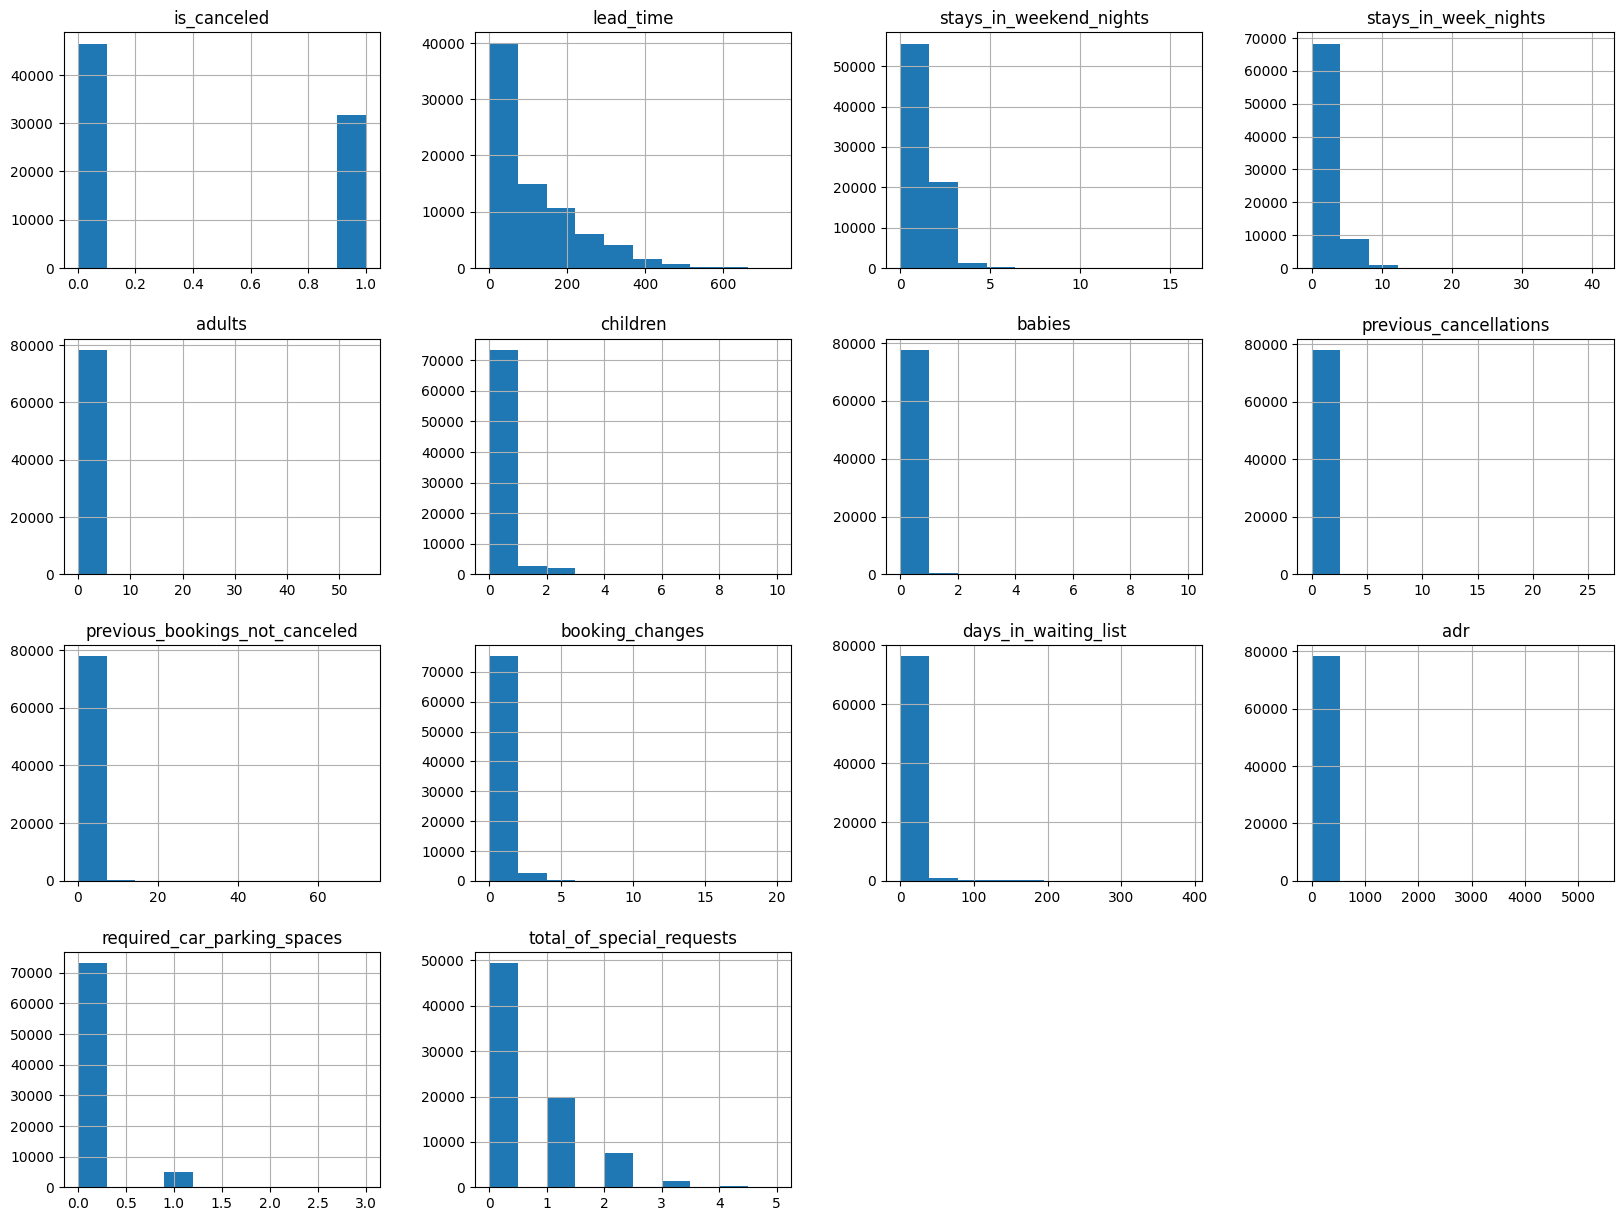

In [65]:
data.hist(figsize = (20,15))

### - Looking at Data Correlation

1. Identifying features with similar information can help reduce the dimensionality of the dataset without significant information loss.
2. Correlation helps to understand the relationships between different variables in a data set.

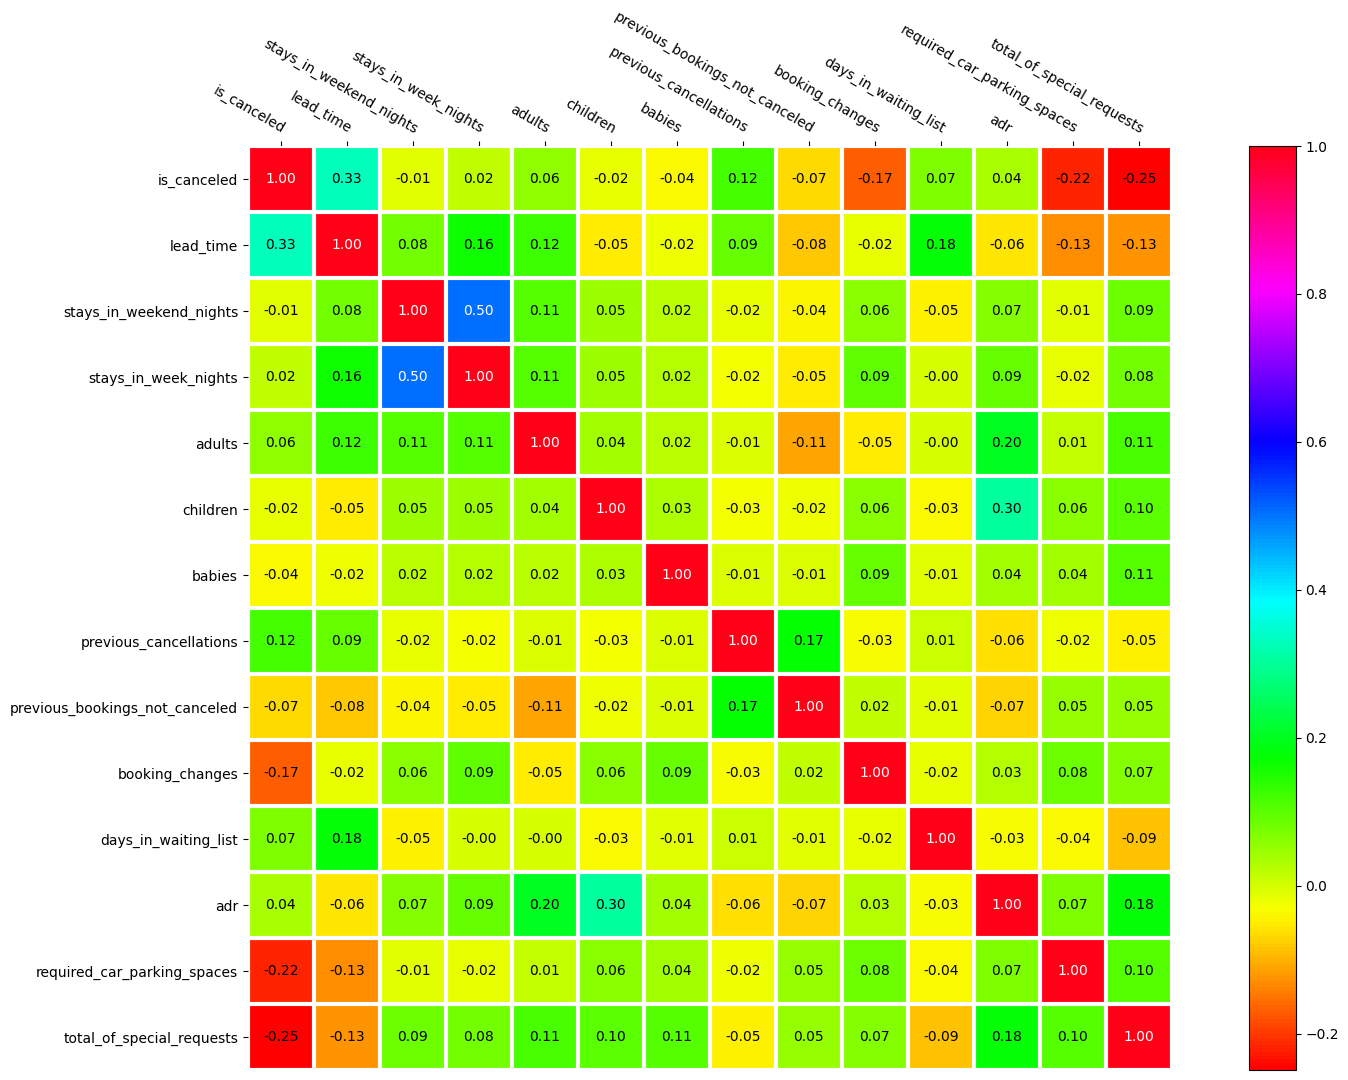

In [66]:
# Select numerical columns
numerical_data = data.select_dtypes(include=['int64', 'float64'])

# Reindex the DataFrame
numerical_data = numerical_data.reset_index(drop=True)

correlations = numerical_data.corr()
columns = list(numerical_data)
#Creates the heatmap
heatmap(correlations.values,columns,columns,figsize = (20,12),cmap="hsv")

### - Find features that correlate with price

Based on the correlation matrix:

positive correlation with 'is_canceled':
- lead_time, previous_cancellations, days_in_waiting_list, adults, adr, stays_in_week_nights

negative correlation with 'is_canceled':
- stays_in_weekend_nights, children, babies, previous_bookings_not_canceled, booking_changes, required_car_parking_spaces, total_of_special_requests

Showing the correlation to the "is_canceled" feature only and sort them in descending order.


In [67]:
correlations["is_canceled"].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.326865
previous_cancellations            0.119779
days_in_waiting_list              0.070788
adults                            0.057672
adr                               0.035499
stays_in_week_nights              0.019326
stays_in_weekend_nights          -0.012625
children                         -0.018874
babies                           -0.035104
previous_bookings_not_canceled   -0.067608
booking_changes                  -0.167776
required_car_parking_spaces      -0.216897
total_of_special_requests        -0.249011
Name: is_canceled, dtype: float64

### - Partition the data into the features and the target data. The target data is is_canceled. 

In [68]:
data_features = data.drop("is_canceled", axis = 1)
data_target = data["is_canceled"].copy()

### - Looking at class balance

We need to ensure that our dataset is balanced. Specifically, we aim to validate that there's an equitable distribution of both cancellations and non-cancellations. This ensures our classifier has a balanced dataset, enabling it to effectively classify both outcomes.

0    46519
1    31768
Name: is_canceled, dtype: int64

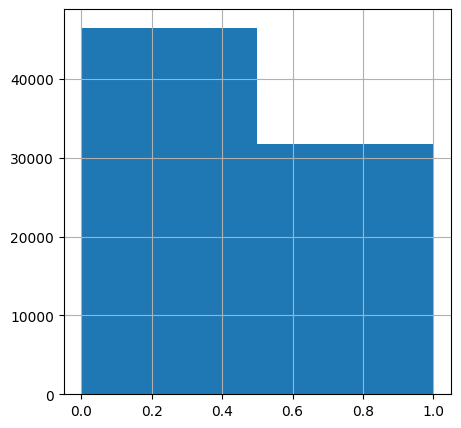

In [69]:
data_target.hist(bins=2, figsize=(5,5))
data_target.value_counts()

### -  Determine which fields need to be dropped

"Name", "email" and "phone number", obviously have nothing to do with the outcome of the attempted prediction, as they may not affect whether the reservation is canceled or not.


In [70]:
data_features = data_features.drop(['phone-number', 'email', 'name'], axis = 1)

### - Augment three feature

- data['total_guests'] = data['adults'] + data['children'] + data['babies']
- data['total_stay_days'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']
- data['total_previous_bookings'] = data['previous_cancellations'] + data['previous_bookings_not_canceled']


In [71]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AugmentFeatures(BaseEstimator, TransformerMixin):
    '''
    data['total_guests'] = data['adults'] + data['children'] + data['babies']
    data['total_stay_days'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']
    data['total_previous_bookings'] = data['previous_cancellations'] + data['previous_bookings_not_canceled']
    '''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        total_guests = X[:, adults_ix] + X[:, child_ix] + X[:, baby_ix]
        total_stay_days = X[:, weekend_night_ix] + X[:, week_night_ix]
        total_previous_bookings = X[:, previous_cancel_ix] + X[:, previous_bookings_not_canceled_ix]
        return np.c_[X, total_guests, total_stay_days, total_previous_bookings]

    def get_feature_names_out(self, input_features=None):
        return np.array(input_features.tolist() + ['total_guests', 'total_stay_days', 'total_previous_bookings'])


adults_ix, child_ix, baby_ix, weekend_night_ix, week_night_ix, previous_cancel_ix, previous_bookings_not_canceled_ix, adr_ix = 4, 5, 6, 2, 3, 9, 10, 16


### - Then partition the feature data into categorical and numerical features.
Rescale the real valued features using StandardScaler

In [72]:
data_categorical_features = data_features.select_dtypes(include=['object', 'bool']).columns
data_numerical_features = data_features.drop(data_categorical_features,axis = 1)

attr_adder = AugmentFeatures() 
data_extra_attribs = attr_adder.transform(data_numerical_features.values) 

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), #Imputes using median
        ('attribs_adder', AugmentFeatures()), #
        ('std_scaler', StandardScaler()),
    ])
    



### - Use One-Hot Encoding on all categorical features with extra feature

In [73]:
# Splits names into numerical and categorical features

numerical_features = list(data_numerical_features)
categorical_features = data_categorical_features

# Applies different transformations on numerical columns vs categorical columns
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", OneHotEncoder(), categorical_features),
])



### - train-test split with 20% of the data going to the test data. 

In [74]:
train_raw, test_raw, target, target_test = train_test_split(data_features, data_target, test_size=0.2, random_state=0)

In [75]:
#Transform raw data 
train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw) 

#Extracts features names for each transformed column
feature_names = full_pipeline.get_feature_names_out(list(data_features.columns))

### - Checking with the test and train data are balanced 

In [76]:
# Print the shapes of the train and test sets
print("train_raw shape:", train_raw.shape)
print("target shape:", target.shape)
print("test_raw shape:", test_raw.shape)
print("target_test shape:", target_test.shape)

train_raw shape: (62629, 20)
target shape: (62629,)
test_raw shape: (15658, 20)
target_test shape: (15658,)


In [77]:
# Print the class counts for the train and test sets
print("Class counts in training set:")
print(target.value_counts())
print("Class counts in testing set:")
print(target_test.value_counts())

Class counts in training set:
0    37171
1    25458
Name: is_canceled, dtype: int64
Class counts in testing set:
0    9348
1    6310
Name: is_canceled, dtype: int64


### Description of what I did for each step
After loading the data and take a closer look at the dataframe, the children has have missing values. Since the missing data size is small, I choose to drop the missing data which would not affect the accuracy of the prediction. For arguments features, I add total_guests to sum all guests including adults, children and babies. The second feature I add is the total_stay_days, which is the number of days staying in hotels. The third feature I add is the total_previous_bookings, which is the number of bookings that have been made. I apply OneHotEncoder to categorical features and StandardScaler to numerical features, keeping extra feature during this process. The data is then split into a balanced 80:20 training-test partition.

## (50 pts) Try out a few models
Now that you have pre-processed your data, you are ready to try out different models. 

For this part of the project, we want you to experiment with all the different models demonstrated in the course to determine which one performs best on the dataset.

You must perform classification using at least 3 of the following models:
- Logistic Regression
- K-nearest neighbors
- SVM
- Decision Tree
- Multi-Layer Perceptron

Due to the size of the dataset, be careful which models you use and look at their documentation to see how you should tackle this size issue for each model.

For full credit, you must perform some hyperparameter optimization on your models of choice. You may find the following scikit-learn library on [hyperparameter optimization](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) useful.

For each model chosen, write a description of which models were chosen, which parameters you optimized, and which parameters you choose for your best model. 
While the previous part of the project asked you to pre-process the data in a specific manner, you may alter pre-processing step as you wish to adjust for your chosen classification models.


### - Conduct a K-Fold Cross-Validation with GridSearch to determine which model perform best and assess its performance on the test set.

In [78]:
k = 3
kf = KFold(n_splits=k, random_state=None)

### - Transform the train data using PCA on the top 10 components

In [79]:
pca = PCA(n_components=10)
train_pca=pca.fit_transform(train)
test_pca=pca.transform(test)

### Model 1: LogisticRegression

Applying with hyperparameter optimization to find out the best model parameters

In [80]:
parameter_lr = {
    'penalty': ["l1", "l2"],
    'C': [0.0001,0.1,1,10],
    'solver': ["liblinear"],
}

clf_lr = LogisticRegression(max_iter=2000)

grid_lr = GridSearchCV(clf_lr, parameter_lr, cv=kf, scoring = "accuracy")
grid_lr.fit(train,target)

res_lr=pd.DataFrame(grid_lr.cv_results_)
res_lr.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.027677      0.002511         0.009613        0.007969  0.0001   
1       0.060399      0.004970         0.003464        0.001348  0.0001   
2       1.119713      0.161223         0.007524        0.005189     0.1   
3       0.294420      0.003126         0.002014        0.000093     0.1   
4       8.995426      1.103912         0.003058        0.000643       1   

  param_penalty param_solver  \
0            l1    liblinear   
1            l2    liblinear   
2            l1    liblinear   
3            l2    liblinear   
4            l1    liblinear   

                                              params  split0_test_score  \
0  {'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...           0.595344   
1  {'C': 0.0001, 'penalty': 'l2', 'solver': 'libl...           0.789721   
2  {'C': 0.1, 'penalty': 'l1', 'solver': 'libline...           0.811180   
3  {'C': 0.1, 'penalty': 'l2', 'solver': 'libline...           0.811323   
4   {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}           0.810605   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.594031           0.591157         0.593511        0.001748   
1           0.789040           0.781903         0.786888        0.003536   
2           0.810740           0.803267         0.808395        0.003631   
3           0.811602           0.803890         0.808938        0.003572   
4           0.811985           0.803171         0.808587        0.003871   

   rank_test_score  
0                8  
1                7  
2                6  
3                1  
4                3

In [81]:
best_model_lr = grid_lr.best_params_
best_score_lr = grid_lr.best_score_

print(f"Best model in logistic regression: {best_model_lr}")
print(f"Best score: {best_score_lr}")

Best model in logistic regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.8089383131591937


**The Best model in logistic regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}**

In [82]:
log_reg = LogisticRegression(penalty = "l2",max_iter = 2000, solver = "liblinear", C=0.1) 

log_reg.fit(train, target)
predicted = log_reg.predict(test)

In [83]:
log_reg_score = metrics.accuracy_score(target_test,predicted)

Accuracy:    0.812747
Precision:   0.844553
Recall:      0.656101
F1 Score:    0.738494
Confusion Matrix: 
 [[8586  762]
 [2170 4140]]


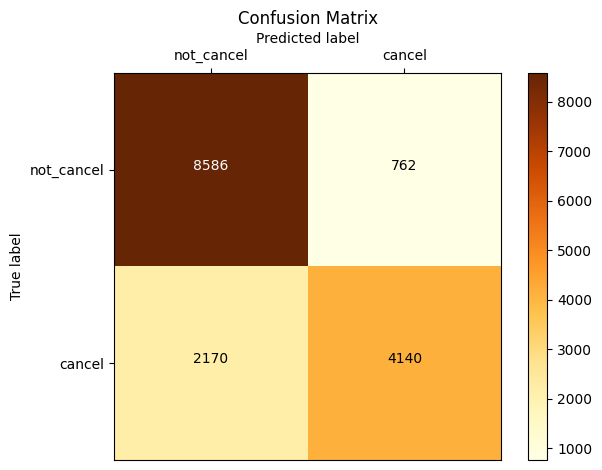

In [84]:
print_confusionMatrix_info(target_test,predicted)
draw_confusion_matrix(target_test, predicted, ['not_cancel', 'cancel'])

**Confusion Matrix with LogisticRegression**

The accuracy of the logistic regression is 0.812747

**Logistic Regression + PCA**

Train the logistic regression with the same parameters as before using train_pca. 

In [85]:
lr_pca = LogisticRegression(penalty = "l2",max_iter = 2000, solver = "liblinear", C=0.1) 
lr_pca.fit(train_pca, target)
predicted = lr_pca.predict(test_pca)

In [86]:
log_reg_score_pca = metrics.accuracy_score(target_test,predicted)

Accuracy LogisticRegression with PCA
Accuracy:    0.758207
Confusion Matrix: 
 [[7938 1410]
 [2376 3934]]


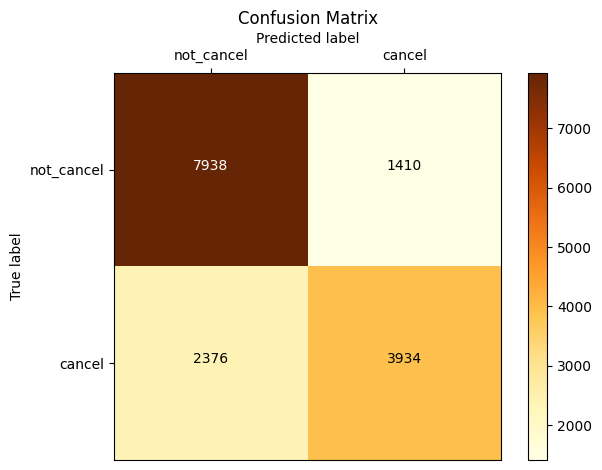

In [87]:
print("Accuracy LogisticRegression with PCA")
print_confusionMatrix_info_pca(target_test,predicted)
draw_confusion_matrix(target_test, predicted, ['not_cancel', 'cancel'])

### Summary for the Logistic Regression Model

The accuracy of the logistic regression is 0.812747. After applying the PCA to the model, the accuracy of the logistic regression is decreased.

### Model 2: KNeighborsClassifier

Applying with hyperparameter optimization to find out the best model parameters

In [88]:
parameters_knn = [
    {
        "n_neighbors": [1,3,5,7,10,15,20,25,30],
        "metric": ["euclidean","manhattan"]
    }
]

clf_knn = KNeighborsClassifier()
grid_knn = GridSearchCV(clf_knn, parameters_knn, cv = kf, scoring = "accuracy")
grid_knn.fit(train,target)

res_knn=pd.DataFrame(grid_knn.cv_results_)
res_knn.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_metric  \
0       0.006125      0.000290         0.990452        0.017141    euclidean   
1       0.005920      0.000283         1.054839        0.107365    euclidean   
2       0.006112      0.000255         0.949725        0.048860    euclidean   
3       0.006012      0.000246         0.990260        0.045526    euclidean   
4       0.006017      0.000088         0.941974        0.030024    euclidean   

  param_n_neighbors                                      params  \
0                 1   {'metric': 'euclidean', 'n_neighbors': 1}   
1                 3   {'metric': 'euclidean', 'n_neighbors': 3}   
2                 5   {'metric': 'euclidean', 'n_neighbors': 5}   
3                 7   {'metric': 'euclidean', 'n_neighbors': 7}   
4                10  {'metric': 'euclidean', 'n_neighbors': 10}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.824496           0.820847           0.819122         0.821488   
1           0.830004           0.826691           0.829134         0.828610   
2           0.829717           0.828751           0.831290         0.829919   
3           0.831250           0.831002           0.830954         0.831069   
4           0.833453           0.832487           0.830571         0.832170   

   std_test_score  rank_test_score  
0        0.002240               18  
1        0.001403               16  
2        0.001046               15  
3        0.000129               12  
4        0.001198               10

In [89]:
best_model_knn = grid_knn.best_params_
best_score_knn = grid_knn.best_score_

print(f"Best model in KNN: {best_model_knn}")
print(f"Best score: {best_score_knn}")

Best model in KNN: {'metric': 'manhattan', 'n_neighbors': 15}
Best score: 0.8353158474606338


**The Best model in KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 15}**

In [90]:
knn = KNeighborsClassifier(n_neighbors=15, metric='manhattan') 

knn.fit(train, target)
testing_result = knn.predict(test)
predicted = knn.predict(test)

In [91]:
knn_score = metrics.accuracy_score(target_test,predicted)

Accuracy:    0.840529
Precision:   0.842957
Recall:      0.742631
F1 Score:    0.789620
Confusion Matrix: 
 [[8475  873]
 [1624 4686]]


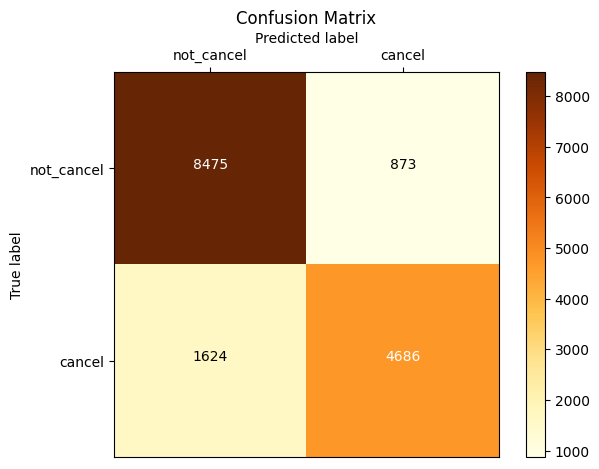

In [92]:
print_confusionMatrix_info(target_test,predicted)
draw_confusion_matrix(target_test, predicted, ['not_cancel', 'cancel'])

**Confusion Matrix with KNeighborsClassifier**

The accuracy of the KNeighborsClassifier is 0.840529

**KNeighborsClassifier  + PCA**

Train the KNeighborsClassifier with the same parameters as before using train_pca. 

In [93]:
knn_pca = KNeighborsClassifier(n_neighbors=15, metric='manhattan') 
knn_pca.fit(train_pca, target)
predicted = knn_pca.predict(test_pca)


In [94]:
knn_score_pca = metrics.accuracy_score(target_test,predicted)

Accuracy KNN with PCA
Accuracy:    0.825010
Confusion Matrix: 
 [[8561  787]
 [1953 4357]]


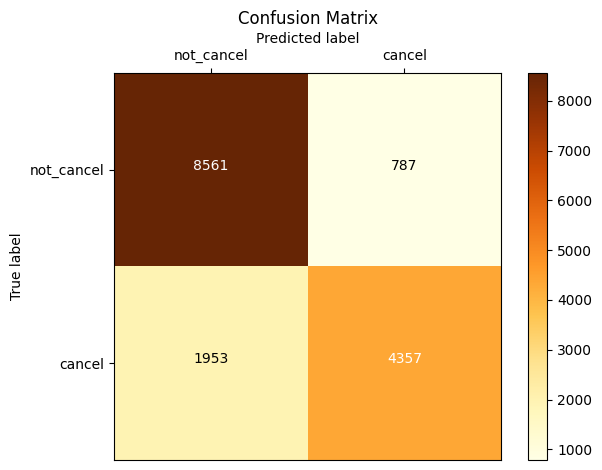

In [95]:
print("Accuracy KNN with PCA")
print_confusionMatrix_info_pca(target_test,predicted)
draw_confusion_matrix(target_test, predicted, ['not_cancel', 'cancel'])

### Summary for the KNeighborsClassifier Model

The accuracy of the KNeighborsClassifier is 0.840529. After applying the PCA to the model, the accuracy of the KNeighborsClassifier is decreased.

### Model 3: SVM

Applying with hyperparameter optimization to find out the best model parameters

In [96]:
parameters_svc = [
    {
        "kernel":["linear", "poly", "rbf", "sigmoid"],
        "C": [0.0001,0.1,10,15,20,30]
    }
]

clf_svc = SVC()
grid_svc = GridSearchCV(clf_svc, parameters_svc, cv = kf, scoring = "accuracy")
grid_svc.fit(train,target)

res_svc=pd.DataFrame(grid_svc.cv_results_)
res_svc.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0      53.838977      0.825543        17.517406        0.093813  0.0001   
1      65.986251      2.016678        21.437098        0.014514  0.0001   
2      78.651558      0.663963        91.915476        2.242970  0.0001   
3      97.227834      2.247153        36.368167        0.285402  0.0001   
4      38.754348      0.554089        11.058143        0.158887     0.1   

  param_kernel                              params  split0_test_score  \
0       linear   {'C': 0.0001, 'kernel': 'linear'}           0.783446   
1         poly     {'C': 0.0001, 'kernel': 'poly'}           0.597116   
2          rbf      {'C': 0.0001, 'kernel': 'rbf'}           0.595344   
3      sigmoid  {'C': 0.0001, 'kernel': 'sigmoid'}           0.595344   
4       linear      {'C': 0.1, 'kernel': 'linear'}           0.810270   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.778262           0.776681         0.779463        0.002889   
1           0.595995           0.592738         0.595283        0.001857   
2           0.594031           0.591157         0.593511        0.001748   
3           0.594031           0.591157         0.593511        0.001748   
4           0.811314           0.805231         0.808938        0.002656   

   rank_test_score  
0               16  
1               22  
2               23  
3               23  
4               13

In [97]:
best_model_svc = grid_svc.best_params_
best_score_svc = grid_svc.best_score_

print(f"Best model in SVC: {best_model_svc}")
print(f"Best score: {best_score_svc}")

Best model in SVC: {'C': 20, 'kernel': 'rbf'}
Best score: 0.855035151170818


**The Best model in SVM: {'C': 20, 'kernel': 'rbf'}**

In [98]:
svc = SVC(kernel = 'rbf', C = 20)

svc.fit(train, target)
testing_result = svc.predict(test)
predicted = svc.predict(test)

In [99]:
svc_score = metrics.accuracy_score(target_test,predicted)

Accuracy:    0.861157
Precision:   0.862299
Recall:      0.780032
F1 Score:    0.819105
Confusion Matrix: 
 [[8562  786]
 [1388 4922]]


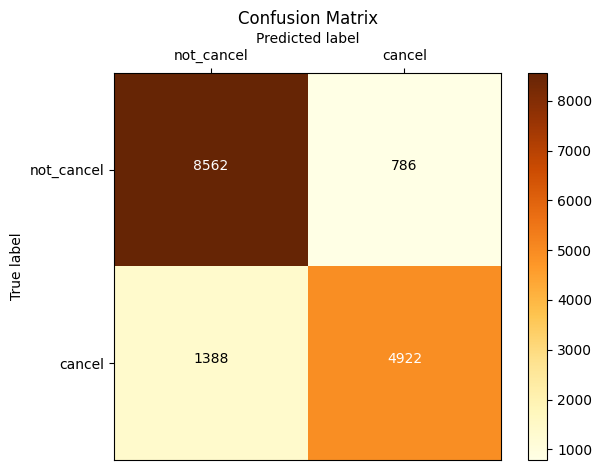

In [100]:
print_confusionMatrix_info(target_test,predicted)
draw_confusion_matrix(target_test, predicted, ['not_cancel', 'cancel'])

**Confusion Matrix with SVM**

The accuracy of the SVM is 0.861157

**SVM  + PCA**

Train the SVM with the same parameters as before using train_pca. 

In [101]:
svc_pca = SVC(kernel = 'rbf', C = 20)
svc_pca.fit(train_pca, target)
predicted = svc_pca.predict(test_pca)


In [102]:
svc_score_pca = metrics.accuracy_score(target_test,predicted)

Accuracy SVC with PCA
Accuracy:    0.823285
Confusion Matrix: 
 [[8785  563]
 [2204 4106]]


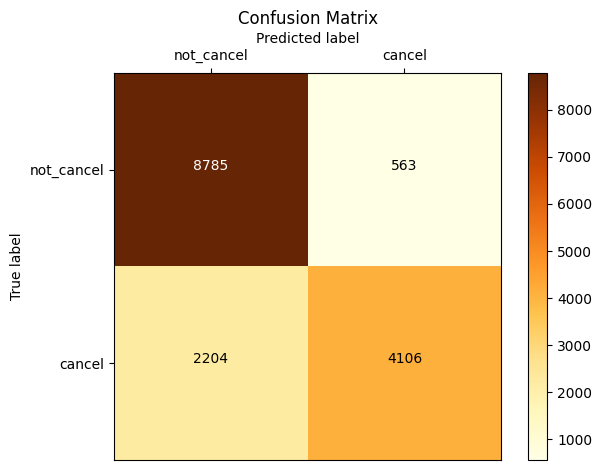

In [103]:
print("Accuracy SVC with PCA")
print_confusionMatrix_info_pca(target_test,predicted)
draw_confusion_matrix(target_test, predicted, ['not_cancel', 'cancel'])

### Summary for the SVM Model

The accuracy of the SVM is 0.861157. After applying the PCA to the model, the accuracy of the SVM is decreased.

### Model 4: DecisionTreeClassifier

Applying with hyperparameter optimization to find out the best model parameters


In [104]:
parameters_dtc = [
    {
        "max_depth": [1,2,3,4,5,10,15,20,30],
        "min_samples_split": [2,4,6,8,10,14,18],
        "criterion": ["gini", "entropy"]
    }
]

clf_dtc = DecisionTreeClassifier(random_state = 0)

grid_dtc = GridSearchCV(clf_dtc, parameters_dtc, cv = kf, scoring = "accuracy")
grid_dtc.fit(train,target)

res_dtc=pd.DataFrame(grid_dtc.cv_results_)
res_dtc.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.034157      0.015149         0.002963        0.000642   
1       0.023496      0.000460         0.003142        0.000320   
2       0.022666      0.000412         0.002623        0.000300   
3       0.022649      0.000541         0.002322        0.000368   
4       0.023030      0.000301         0.002262        0.000087   

  param_criterion param_max_depth param_min_samples_split  \
0            gini               1                       2   
1            gini               1                       4   
2            gini               1                       6   
3            gini               1                       8   
4            gini               1                      10   

                                              params  split0_test_score  \
0  {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.761029   
1  {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.761029   
2  {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.761029   
3  {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.761029   
4  {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.761029   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.757042           0.754503         0.757524        0.002686   
1           0.757042           0.754503         0.757524        0.002686   
2           0.757042           0.754503         0.757524        0.002686   
3           0.757042           0.754503         0.757524        0.002686   
4           0.757042           0.754503         0.757524        0.002686   

   rank_test_score  
0              113  
1              113  
2              113  
3              113  
4              113

In [105]:
best_model_dtc = grid_dtc.best_params_
best_score_dtc = grid_dtc.best_score_

print(f"Best model in DecisionTreeClassifier: {best_model_dtc}")
print(f"Best score: {best_score_dtc}")

Best model in DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}
Best score: 0.8409522328687097


**Best model in DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}**


In [106]:
dtc = DecisionTreeClassifier(criterion = "gini", max_depth = 20, min_samples_split = 2, random_state = 0)

dtc.fit(train, target)
testing_result = dtc.predict(test)
predicted = dtc.predict(test)

In [107]:
dtc_score = metrics.accuracy_score(target_test,predicted)

Accuracy:    0.848129
Precision:   0.817917
Recall:      0.801585
F1 Score:    0.809669
Confusion Matrix: 
 [[8222 1126]
 [1252 5058]]


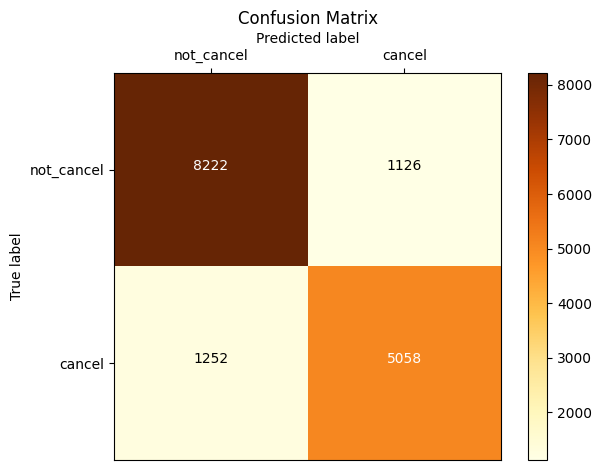

In [108]:
print_confusionMatrix_info(target_test,predicted)
draw_confusion_matrix(target_test, predicted, ['not_cancel', 'cancel'])

**Confusion Matrix with DecisionTreeClassifier**

The accuracy of the DecisionTreeClassifier is 0.848129

### - Feature Importance in Decision Trees

The decision tree ranks the importance of features based on the average impurity reduction brought by each feature. In the model, features that cause a greater impurity reduction are considered more important for decision making.

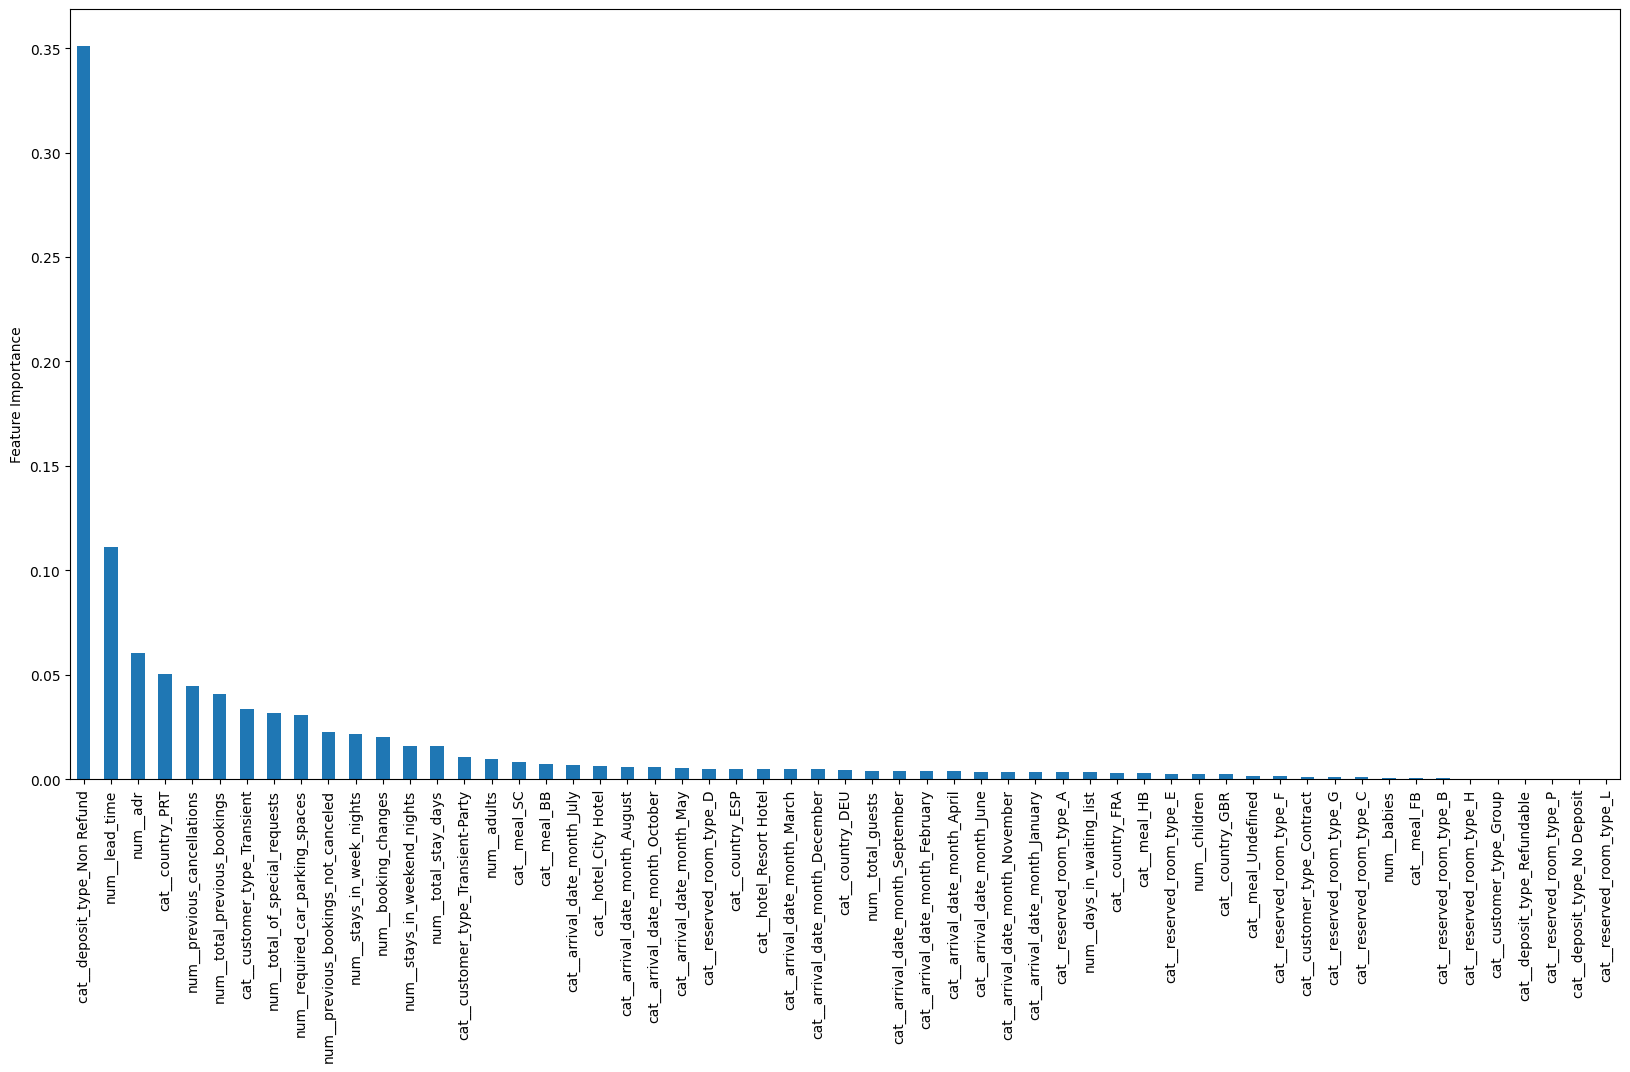

In [109]:
imp_pd = pd.Series(data=dtc.feature_importances_, index=feature_names)
imp_pd = imp_pd.sort_values(ascending=False)
imp_pd.plot.bar(figsize=(20, 10)) 
plt.ylabel('Feature Importance')
plt.show()

**DecisionTreeClassifier + PCA**

Train the DecisionTreeClassifier with the same parameters as before using train_pca. 

In [110]:
dtc_pca = DecisionTreeClassifier(criterion = "gini", max_depth = 20, min_samples_split = 2, random_state = 0)
dtc_pca.fit(train_pca, target)
predicted = dtc_pca.predict(test_pca)


In [111]:
dtc_score_pca = metrics.accuracy_score(target_test,predicted)

Accuracy DecisionTree with PCA
Accuracy:    0.816579
Confusion Matrix: 
 [[8036 1312]
 [1560 4750]]


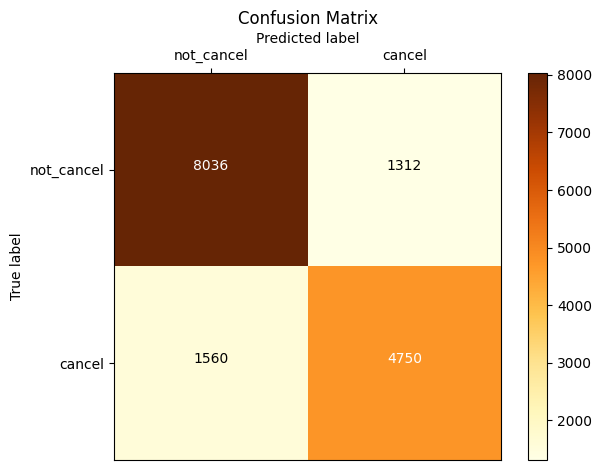

In [112]:
print("Accuracy DecisionTree with PCA")
print_confusionMatrix_info_pca(target_test,predicted)
draw_confusion_matrix(target_test, predicted, ['not_cancel', 'cancel'])

### Summary for the DecisionTreeClassifier Model

The accuracy of the DecisionTreeClassifier is 0.848129. After applying the PCA to the model, the accuracy of the DecisionTreeClassifier is decreased.

### Model 5: MLPClassifier

Applying with hyperparameter optimization to find out the best model parameters

In [113]:
parameter_mlp = {
    'hidden_layer_sizes': [(50,), (150,), (300,), (500,),(1000,), (2500,)] 
}

clf_mlp = MLPClassifier(max_iter=2000)

grid_mlp = GridSearchCV(clf_mlp, parameter_mlp, n_jobs=-1, cv=kf, scoring = "accuracy")
grid_mlp.fit(train,target)

res_clf=pd.DataFrame(grid_mlp.cv_results_)
res_clf.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      14.989967      0.934438         0.014542        0.002418   
1      48.632897      6.798640         0.029749        0.005888   
2      92.354306     16.082861         0.062737        0.005191   
3     131.962287      5.554723         0.082239        0.008982   
4     219.449954      2.877734         0.157501        0.018919   

  param_hidden_layer_sizes                           params  \
0                    (50,)    {'hidden_layer_sizes': (50,)}   
1                   (150,)   {'hidden_layer_sizes': (150,)}   
2                   (300,)   {'hidden_layer_sizes': (300,)}   
3                   (500,)   {'hidden_layer_sizes': (500,)}   
4                  (1000,)  {'hidden_layer_sizes': (1000,)}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.858552           0.854330           0.848726         0.853870   
1           0.857499           0.852127           0.847193         0.852273   
2           0.852661           0.854426           0.849492         0.852193   
3           0.859846           0.854187           0.853133         0.855722   
4           0.860229           0.856582           0.852989         0.856600   

   std_test_score  rank_test_score  
0        0.004025                3  
1        0.004209                5  
2        0.002041                6  
3        0.002948                2  
4        0.002956                1

In [114]:
best_model_mlp = grid_mlp.best_params_
best_score_mlp = grid_mlp.best_score_

print(f"Best model in MLPClassifier: {best_model_mlp}")
print(f"Best score: {best_score_mlp}")

Best model in MLPClassifier: {'hidden_layer_sizes': (1000,)}
Best score: 0.8565999197010905


**Best model in MLPClassifier: {'hidden_layer_sizes': (1000,)}**

In [115]:
mlp = MLPClassifier(hidden_layer_sizes=(1000,), max_iter=2000)

mlp.fit(train, target)
testing_result = mlp.predict(test)
predicted = mlp.predict(test)


In [116]:
mlp_score = metrics.accuracy_score(target_test,predicted)

Accuracy:    0.853877
Precision:   0.808720
Recall:      0.834865
F1 Score:    0.821585
Confusion Matrix: 
 [[8102 1246]
 [1042 5268]]


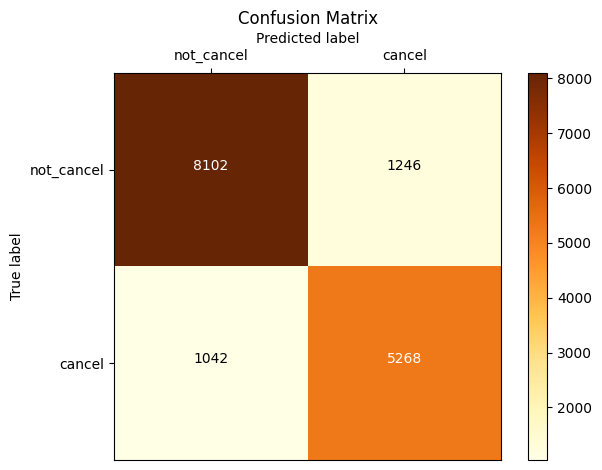

In [117]:
print_confusionMatrix_info(target_test,predicted)
draw_confusion_matrix(target_test, predicted, ['not_cancel', 'cancel'])

**Confusion Matrix with MLPClassifier**

The accuracy of the MLPClassifier is 0.853877.

In [118]:
mlp_pca = MLPClassifier(hidden_layer_sizes=(1000,), max_iter=2000)
mlp_pca.fit(train_pca, target)
predicted = mlp_pca.predict(test_pca)

In [119]:
mlp_score_pca = metrics.accuracy_score(target_test,predicted)

Accuracy MLP with PCA
Accuracy:    0.842062
Confusion Matrix: 
 [[8713  635]
 [1838 4472]]


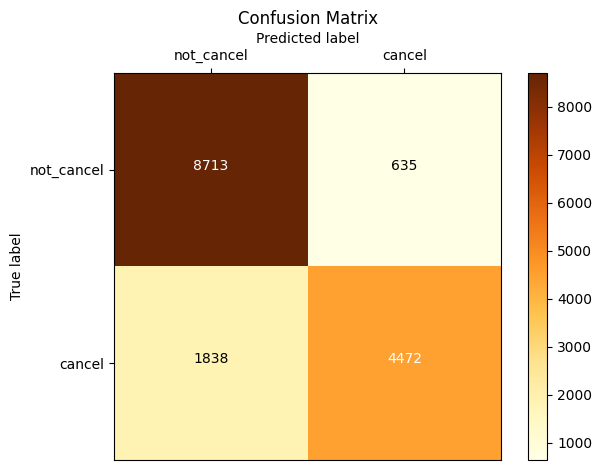

In [120]:
print("Accuracy MLP with PCA")
print_confusionMatrix_info_pca(target_test,predicted)
draw_confusion_matrix(target_test, predicted, ['not_cancel', 'cancel'])

### Summary for the MLPClassifier Model

The accuracy of the MLPClassifier is 0.853877. After applying the PCA to the model, the accuracy of the MLPClassifier is decreased.

### Find the best model

In [121]:
score = [log_reg_score, knn_score, svc_score, dtc_score, mlp_score]

score_pca = [log_reg_score_pca, knn_score_pca, svc_score_pca, dtc_score_pca, mlp_score_pca]

max_score_pca = max(score_pca)
max_score = max(score)

print("The highest accuracy Model is ")
if max_score == log_reg_score:
    print("Logistic Regression")
elif max_score == knn_score:
    print("KNeighborsClassifier")
elif max_score == svc_score:
    print("SVC")
elif max_score == dtc_score:
    print("DecisionTreeClassifier")
else:
    print("MLPClassifier")

print(" with accuracy = ", max_score)

print("The highest accuracy Model in PCA is ")
if max_score_pca == log_reg_score_pca:
    print("Logistic Regression")
elif max_score_pca == knn_score_pca:
    print("KNeighborsClassifier")
elif max_score_pca == svc_score_pca:
    print("SVC")
elif max_score_pca == dtc_score_pca:
    print("DecisionTreeClassifier")
else:
    print("MLPClassifier")

print(" with accuracy = ", max_score_pca)

The highest accuracy Model is 
SVC
 with accuracy =  0.8611572359177417
The highest accuracy Model in PCA is 
MLPClassifier
 with accuracy =  0.8420615659726657


### Description

I conducted K-Fold Cross Validation with k = 3 to evaluate the model accuracy without applying PCA. Then, I applied PCA to the data and assessed the impact on the accuracy for different model parameters.

1. Logistic Regression: The best model parameters {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'} achieved an accuracy of 0.812747. However, applying PCA resulted in a decrease in accuracy.
2. K-nearest neighbor: The best model parameters {'metric': 'manhattan', 'n_neighbors': 15} achieved an accuracy of 0.840529. Similarly, applying PCA led to a decrease in accuracy.
3. SVM: The best model parameters {'C': 20, 'kernel': 'rbf'} achieved an accuracy of 0.861157. Once again, the accuracy decreased after applying PCA.
4. Decision Tree: The best parameters {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2} revealed that the most important feature in the decision tree is 'deposit_type_Non Refund'. However, the accuracy decreased when PCA was applied.
5. Multi-Layer Perceptron: The best parameter {'hidden_layer_sizes': (1000,)} achieved the highest accuracy of 0.853877. Unfortunately, applying PCA resulted in a decrease in accuracy.

Considering the highest accuracy achieved by the SVM model, I will select it for the extra credit part, utilizing the parameters {'C': 20, 'kernel': 'rbf'}

## Extra Credit 

We have provided an extra test dataset named "hotel_booking_test.csv" that does not have the target labels. Classify the samples in the dataset with your best model and write them into a csv file. Submit your csv file to our [Kaggle](https://www.kaggle.com/t/ed725123bf124e9199c1d8fdc8a2d9c7) contest. The website will specify your classification accuracy on the test set. We will award a bonus point for the project for every percentage point over 75% that you get on your kaggle test accuracy.

To get the bonus points, you must also write out a summary of the model that you submit including any changes you made to the pre-processing steps. The summary must be written in a markdown cell of the jupyter notebook. Note that you should not change earlier parts of the project to complete the extra credit. 

**Kaggle Submission Instruction**
Submit a two column csv where the first column is named "ID" and is the row number. The second column is named "target" and is the classification for each sample. Make sure that the sample order is preserved.

In [135]:
data_test = pd.read_csv('datasets/hotel_booking_test.csv')
data_test.head()

hotel  lead_time arrival_date_month  stays_in_weekend_nights  \
0    City Hotel        177             August                        0   
1  Resort Hotel        217             August                        2   
2    City Hotel         65          September                        2   
3    City Hotel        377            October                        0   
4    City Hotel         75                May                        2   

   stays_in_week_nights  adults  children  babies meal country  ...  \
0                     2       2       0.0       0   SC     FRA  ...   
1                     5       2       1.0       0   HB     PRT  ...   
2                     1       2       0.0       0   HB     PRT  ...   
3                     2       2       0.0       0   HB     DEU  ...   
4                     1       2       0.0       0   BB     PRT  ...   

   booking_changes  deposit_type days_in_waiting_list    customer_type    adr  \
0                0    No Deposit                    0        Transient   94.5   
1                0    No Deposit                    0        Transient  170.0   
2                0    Non Refund                    0        Transient   86.0   
3                0    No Deposit                    0  Transient-Party  115.0   
4                0    No Deposit                    0  Transient-Party   90.0   

   required_car_parking_spaces total_of_special_requests             name  \
0                            0                         1  Wendy Moore DDS   
1                            0                         0   Brandon Fields   
2                            0                         0      Chad Peters   
3                            0                         1    Colin Rosario   
4                            0                         0       Dana Booth   

                          email  phone-number  
0             Wendy_D50@att.com  350-596-1114  
1              BFields@zoho.com  872-706-9025  
2       Peters.Chad@outlook.com  581-621-8941  
3  Rosario_Colin@protonmail.com  783-552-8468  
4      Dana_Booth22@outlook.com  194-105-9813  

[5 rows x 23 columns]

In [136]:
data_test.describe()

lead_time  stays_in_weekend_nights  stays_in_week_nights  \
count  8699.000000              8699.000000           8699.000000   
mean    107.529256                 0.863433              2.413956   
std     113.003691                 0.988655              1.876331   
min       0.000000                 0.000000              0.000000   
25%      17.000000                 0.000000              1.000000   
50%      69.000000                 1.000000              2.000000   
75%     166.000000                 2.000000              3.000000   
max     629.000000                14.000000             35.000000   

            adults     children       babies  previous_cancellations  \
count  8699.000000  8698.000000  8699.000000             8699.000000   
mean      1.838257     0.095309     0.008162                0.109668   
std       0.484934     0.381531     0.089979                0.847770   
min       0.000000     0.000000     0.000000                0.000000   
25%       2.000000     0.000000     0.000000                0.000000   
50%       2.000000     0.000000     0.000000                0.000000   
75%       2.000000     0.000000     0.000000                0.000000   
max       4.000000     3.000000     1.000000               26.000000   

       previous_bookings_not_canceled  booking_changes  days_in_waiting_list  \
count                     8699.000000      8699.000000           8699.000000   
mean                         0.182435         0.211978              2.548914   
std                          1.645575         0.656530             18.373929   
min                          0.000000         0.000000              0.000000   
25%                          0.000000         0.000000              0.000000   
50%                          0.000000         0.000000              0.000000   
75%                          0.000000         0.000000              0.000000   
max                         70.000000        21.000000            391.000000   

               adr  required_car_parking_spaces  total_of_special_requests  
count  8699.000000                  8699.000000                8699.000000  
mean     98.545044                     0.067019                   0.521554  
std      49.416682                     0.250987                   0.770423  
min       0.000000                     0.000000                   0.000000  
25%      65.000000                     0.000000                   0.000000  
50%      90.000000                     0.000000                   0.000000  
75%     120.700000                     0.000000                   1.000000  
max     451.500000                     2.000000                   4.000000

In [137]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8699 entries, 0 to 8698
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           8699 non-null   object 
 1   lead_time                       8699 non-null   int64  
 2   arrival_date_month              8699 non-null   object 
 3   stays_in_weekend_nights         8699 non-null   int64  
 4   stays_in_week_nights            8699 non-null   int64  
 5   adults                          8699 non-null   int64  
 6   children                        8698 non-null   float64
 7   babies                          8699 non-null   int64  
 8   meal                            8699 non-null   object 
 9   country                         8699 non-null   object 
 10  previous_cancellations          8699 non-null   int64  
 11  previous_bookings_not_canceled  8699 non-null   int64  
 12  reserved_room_type              86

In [138]:
print(data_test.nunique())

hotel                                2
lead_time                          445
arrival_date_month                  12
stays_in_weekend_nights             10
stays_in_week_nights                21
adults                               5
children                             4
babies                               2
meal                                 5
country                              5
previous_cancellations              13
previous_bookings_not_canceled      30
reserved_room_type                   9
booking_changes                     12
deposit_type                         3
days_in_waiting_list                80
customer_type                        4
adr                               1833
required_car_parking_spaces          3
total_of_special_requests            5
name                              8257
email                             8680
phone-number                      8699
dtype: int64


In [139]:
data_test.isnull().sum()

hotel                             0
lead_time                         0
arrival_date_month                0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          1
babies                            0
meal                              0
country                           0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
name                              0
email                             0
phone-number                      0
dtype: int64

In [140]:
median = data_test["children"].median() 
data_test["children"].fillna(median, inplace=True)

In [141]:
data_test.isnull().sum()

hotel                             0
lead_time                         0
arrival_date_month                0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
name                              0
email                             0
phone-number                      0
dtype: int64

In [142]:
data_test = data_test.drop(['phone-number', 'email', 'name'], axis = 1)

In [143]:
data_test_categorical_features = data_test.select_dtypes(include=['object', 'bool']).columns
data_test_numerical_features = data_test.drop(data_test_categorical_features,axis = 1)

attr_adder_test = AugmentFeatures() 

num_pipeline_test = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), #Imputes using median
        ('attribs_adder_test', AugmentFeatures()), #
        ('std_scaler', StandardScaler()),
    ])
    

In [144]:
numerical_features = list(data_test_numerical_features)
categorical_features = data_test_categorical_features

# Applies different transformations on numerical columns vs categorical columns
full_pipeline_test = ColumnTransformer([
    ("num", num_pipeline_test, numerical_features),
    ("cat", OneHotEncoder(), categorical_features),
])

In [145]:
test_ec = full_pipeline.transform(data_test) 

In [146]:
predictions_ec = svc.predict(test_ec)
print(predictions_ec)

[0 1 1 ... 0 0 0]


In [147]:
df = pd.DataFrame(predictions_ec, columns=['target'])
df.head()

target
0       0
1       1
2       1
3       0
4       1

In [148]:
df.to_csv("extra_credit.csv", index=True, index_label="ID")

## Summary

After checking the "hotel_booking_test.csv" test dataset, I proceeded with the following data pre-processing steps. Given the minimal amount of missing data, I chose to fill it with the median value of this column. Some columns, such as "phone number", "email" and "name", were dropped as they were not relevant to our analysis.

Pre-processing includes OneHotEncoding of the categorical data and StandardScaler of the numerical data.

These pre-processing steps are integrated into a function called "full_pipeline" to simplify data processing. The SVM model was selected for its superior performance compared to other models.